# CNC Mill Tool Wear


## Table of contents<a name=top></a>1. [Data describtion](#des)<br> 
1. [Import libraries](#import)<br> 
1. [Load Datasets](#load)<br>
1. [Pre-processing](#pre)<br>
    * [Missing values](#miss)<br>
    * [Merge Data](#merge)<br>
    * [Visualization and statistical analysis](#vis)<br>
    * [Preparing data](#prepare)<br>
1. [Training model with Random Forest Classifier](#trainrf)<br>
1. [Training model with Decision Tree](#traindt)<br>
1. [Training model with XGBoost Model](#trainxgb)<br>
1. [Training model with RNN](#traincnn)

## Data describtion<a name=des></a>
In this project, a CNC milling machine was used to perform machining experiments. The CNC machine recorded machining data for different settings of tool condition, feed rate, and clamping pressure. More details about the dataset can be found [here](https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill/data).<br>
The CNC machine had 4 motors (X, Y, Z axes and spindle) that generated time series data with a 100 ms interval in 18 machining experiments. The output of each experiment showed the tool condition (whether the tool was worn or not) and the result of visual inspection. This dataset is useful for finding tool wear or poor clamping.

## Import libraries<a name=import></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, LSTM

import warnings
warnings.filterwarnings('ignore')

## Load datasets<a name=load></a>

In [2]:
train_data=pd.read_csv(r'E:/proj/train.csv')
print(f'shape of train_data : {train_data.shape}')
train_data.head(2)

shape of train_data : (18, 7)


No material  feedrate  clamp_pressure tool_condition machining_finalized  \
0   1      wax         6             4.0         unworn                 yes   
1   2      wax        20             4.0         unworn                 yes   

  passed_visual_inspection  
0                      yes  
1                      yes

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        18 non-null     int64  
 1   material                  18 non-null     object 
 2   feedrate                  18 non-null     int64  
 3   clamp_pressure            18 non-null     float64
 4   tool_condition            18 non-null     object 
 5   machining_finalized       18 non-null     object 
 6   passed_visual_inspection  14 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ KB


In [4]:
experiment_01 = pd.read_csv(r"E:/proj/experiment_01.csv")
print(f'shape of experiment_01 : {experiment_01.shape}')
experiment_01.head(2)

shape of experiment_01 : (1055, 48)


X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0              -10.8                 -350.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0               -13.6                  -358.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   

   ...  S1_CurrentFeedback  S1_DCBusVoltage  S1_OutputCurrent  \
0  ...               0.524     2.740000e-19             329.0   
1  ...              -0.288     2.740000e-19             328.0   

   S1_OutputVoltage  S1_OutputPower  S1_SystemInertia  \
0               0.0    6.960000e-07              12.0   
1               0.0   -5.270000e-07              12.0   

   M1_CURRENT_PROGRAM_NUMBER  M1_sequence_number  M1_CURRENT_FEEDRATE  \
0                        1.0                 0.0                 50.0   
1                        1.0                 4.0                 50.0   

   Machining_Process  
0           Starting  
1               Prep  

[2 rows x 48 columns]

In [5]:
experiment_02 = pd.read_csv(r"E:/proj/experiment_02.csv")
print(f'shape of experiment_02 : {experiment_02.shape}')
experiment_02.head(2)

shape of experiment_02 : (1668, 48)


X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0                0.0                    0.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0                 0.0                     0.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0              -0.284     2.790000e-19             329.0               0.0   
1              -0.284     2.790000e-19             329.0               0.0   

   ...  S1_CurrentFeedback  S1_DCBusVoltage  S1_OutputCurrent  \
0  ...               -1.86              0.0             332.0   
1  ...               -1.86              0.0             332.0   

   S1_OutputVoltage  S1_OutputPower  S1_SystemInertia  \
0               0.0             0.0              12.0   
1               0.0             0.0              12.0   

   M1_CURRENT_PROGRAM_NUMBER  M1_sequence_number  M1_CURRENT_FEEDRATE  \
0                        1.0                 2.0                 50.0   
1                        0.0                 0.0                 50.0   

   Machining_Process  
0               Prep  
1               Prep  

[2 rows x 48 columns]

## Pre-processing<a name=pre></a>
### Missing_values<a name=miss></a>
As it is seen in the `train_data.info()`, the `train_data` has some Non-values in the column passed_visual_inspection, which is indeed "No", i.e. the machining process was not passed the final test. Therefore, we can replace these missing-values by "No".

In [6]:
train_data['passed_visual_inspection'].fillna('no',inplace=True)
train_data.head()

No material  feedrate  clamp_pressure tool_condition machining_finalized  \
0   1      wax         6             4.0         unworn                 yes   
1   2      wax        20             4.0         unworn                 yes   
2   3      wax         6             3.0         unworn                 yes   
3   4      wax         6             2.5         unworn                  no   
4   5      wax        20             3.0         unworn                  no   

  passed_visual_inspection  
0                      yes  
1                      yes  
2                      yes  
3                       no  
4                       no

## Merge data<a name=merge></a>
We can merge all experiments and add each row of train_data to the experiments. As you can see in the 'material' column, the only material is "Wax". Therefore, we can drop this column.

In [7]:
train_data['material'].unique()

array(['wax'], dtype=object)

In [8]:
Merge_frame = []
for i in range(1,19):
    exp_number = '0' + str(i) if i < 10 else str(i)
    exp_data = pd.read_csv(f"E:/proj/experiment_{exp_number}.csv")

    train_data_row = train_data[train_data['No'] == i]
    exp_data['exp_number'] = i
    #add each column of our train_data to the experiments
    exp_data['feedrate'] = train_data_row.iloc[0]['feedrate']
    exp_data['clamp_pressure'] = train_data_row.iloc[0]['clamp_pressure']
    exp_data['tool_condition'] = train_data_row.iloc[0]['tool_condition']
    exp_data['machining_finalized'] = train_data_row.iloc[0]['machining_finalized']
    exp_data['passed_visual_inspection'] = train_data_row.iloc[0]['passed_visual_inspection']

    Merge_frame.append(exp_data)

merged_data = pd.concat(Merge_frame, ignore_index = True)
merged_data.head(2)

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0              -10.8                 -350.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0               -13.6                  -358.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   

   ...  M1_CURRENT_PROGRAM_NUMBER  M1_sequence_number  M1_CURRENT_FEEDRATE  \
0  ...                        1.0                 0.0                 50.0   
1  ...                        1.0                 4.0                 50.0   

   Machining_Process  exp_number  feedrate  clamp_pressure  tool_condition  \
0           Starting           1         6             4.0          unworn   
1               Prep           1         6             4.0          unworn   

   machining_finalized  passed_visual_inspection  
0                  yes                       yes  
1                  yes                       yes  

[2 rows x 54 columns]

In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

In [10]:
merged_data['Machining_Process'].unique()

array(['Starting', 'Prep', 'Layer 1 Up', 'Layer 1 Down', 'Repositioning',
       'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down', 'end',
       'End'], dtype=object)

In [11]:
merged_data['Machining_Process'].value_counts()

Machining_Process
Layer 1 Up       4085
Repositioning    3377
Layer 2 Up       3104
Layer 3 Up       2794
Layer 1 Down     2655
End              2585
Layer 2 Down     2528
Layer 3 Down     2354
Prep             1795
end                 8
Starting            1
Name: count, dtype: int64

#### Note
I assume 'End' and 'end' are the same result in the "Machining_Process" column. So we can use only 'End'. In addition, we have only one row with the value "Starting", so I think it can be included in the "Prep" category.

In [12]:
merged_data.replace({'Machining_Process':{'end':'End','Starting':'Prep'}},inplace=True)
merged_data['Machining_Process'].unique()

array(['Prep', 'Layer 1 Up', 'Layer 1 Down', 'Repositioning',
       'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down', 'End'],
      dtype=object)

## Visualization and statistical analysis<a name=vis></a>
Now we should see the relation between the data, how they spread and get more information about them.

In [13]:
merged_data.describe()

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
count       25286.000000       25286.000000           25286.000000   
mean          159.052045          -0.288657               0.094264   
std            19.330873           5.658260              93.877623   
min           141.000000         -20.400000           -1280.000000   
25%           145.000000          -2.050000             -31.300000   
50%           153.000000           0.000000               0.000000   
75%           162.000000           0.200000              25.000000   
max           198.000000          50.700000            1440.000000   

       X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
count        25286.000000        25286.000000            25286.000000   
mean           159.050700           -0.283076                0.253215   
std             19.331144            5.664309               72.594951   
min            141.000000          -20.000000            -1000.000000   
25%            145.000000           -2.050000                0.000000   
50%            153.000000            0.000000                0.000000   
75%            162.000000            0.000000                0.000000   
max            198.000000           50.000000             1000.000000   

       X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  \
count        25286.000000     2.528600e+04      25286.000000   
mean            -0.469714     6.603073e-02        326.945859   
std              4.220750     3.700384e-02          1.459937   
min            -23.400000     2.780000e-19        320.000000   
25%             -3.930000     4.150000e-02        326.000000   
50%             -0.666000     6.680000e-02        327.000000   
75%              3.140000     9.130000e-02        327.000000   
max             27.100000     3.800000e-01        331.000000   

       X1_OutputVoltage  ...  S1_OutputCurrent  S1_OutputVoltage  \
count      25286.000000  ...      25286.000000      25286.000000   
mean           7.986942  ...        322.784505         85.479195   
std            7.710379  ...          4.293571         52.531863   
min            0.000000  ...        290.000000          0.000000   
25%            2.590000  ...        320.000000          0.000000   
50%            7.140000  ...        322.000000        117.000000   
75%           10.200000  ...        327.000000        119.000000   
max           75.400000  ...        332.000000        130.000000   

       S1_OutputPower  S1_SystemInertia  M1_CURRENT_PROGRAM_NUMBER  \
count    25286.000000           25286.0               25286.000000   
mean         0.127405              12.0                   1.003441   
std          0.080753               0.0                   0.349055   
min         -0.002960              12.0                   0.000000   
25%          0.000005              12.0                   1.000000   
50%          0.164000              12.0                   1.000000   
75%          0.183000              12.0                   1.000000   
max          0.569000              12.0                   4.000000   

       M1_sequence_number  M1_CURRENT_FEEDRATE    exp_number      feedrate  \
count        25286.000000         25286.000000  25286.000000  25286.000000   
mean            47.345013            16.542039     10.738235      7.123942   
std             43.826214            19.620219      5.213285      6.167036   
min              0.000000             3.000000      1.000000      3.000000   
25%              2.000000             3.000000      6.000000      3.000000   
50%             39.000000             6.000000     12.000000      3.000000   
75%             85.000000            20.000000     15.000000      6.000000   
max            135.000000            50.000000     18.000000     20.000000   

       clamp_pressure  
count    25286.000000  
mean         3.368168  
std          0.615639  
min          2.500000  
25%          3.000000  
50%          3.000000  
75%          4.000000  
ma

#### Note
First, check the boxplot and histplot to see the distribution of the data. So we may find out if we should normalize the data before proceeding with our model. Or in case we want to normalize, is there any outlier or not.

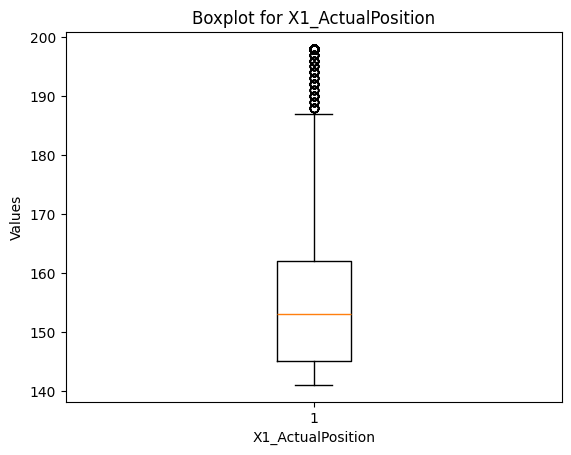

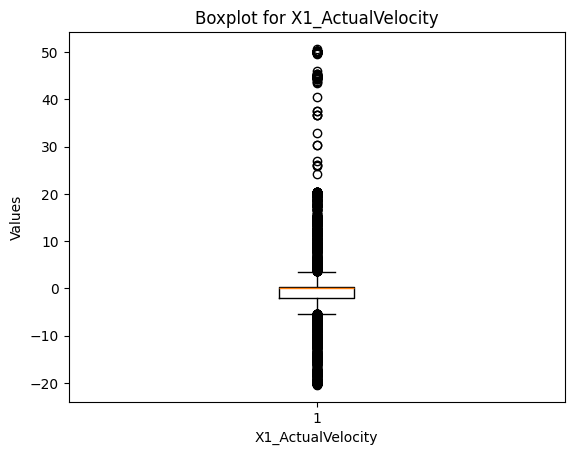

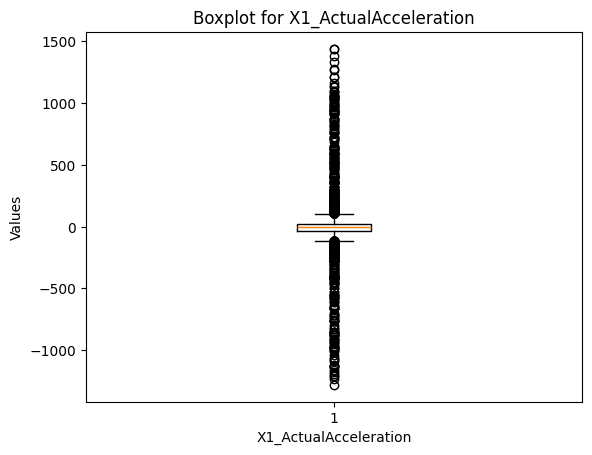

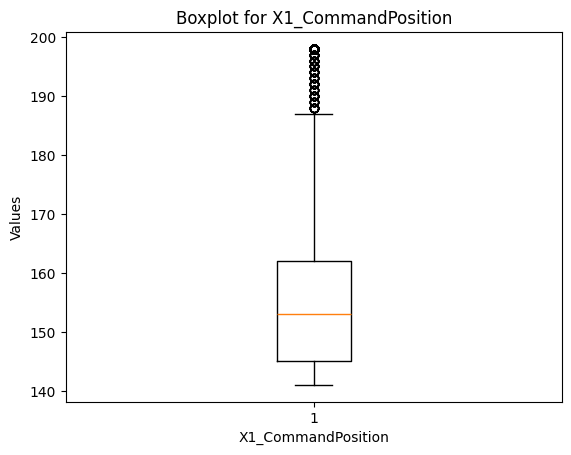

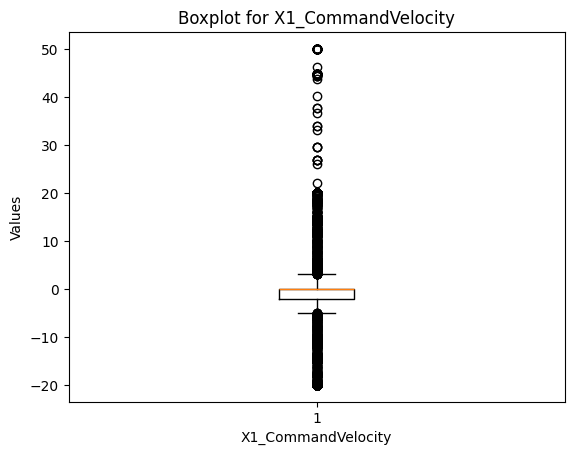

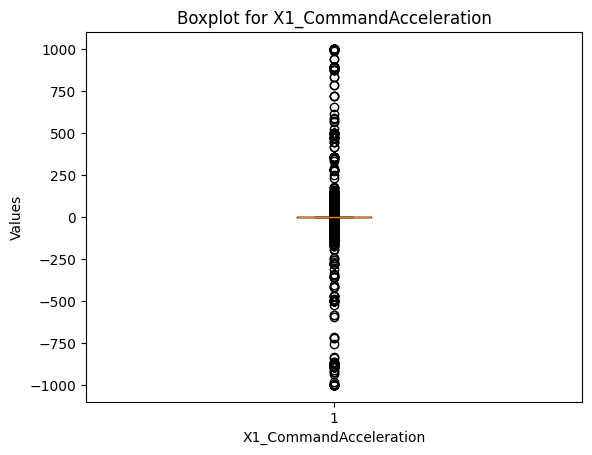

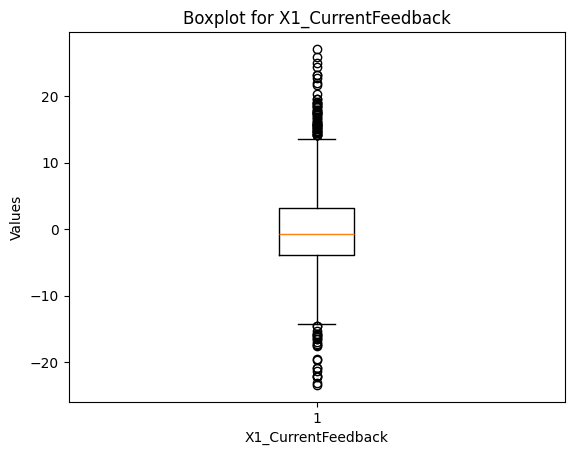

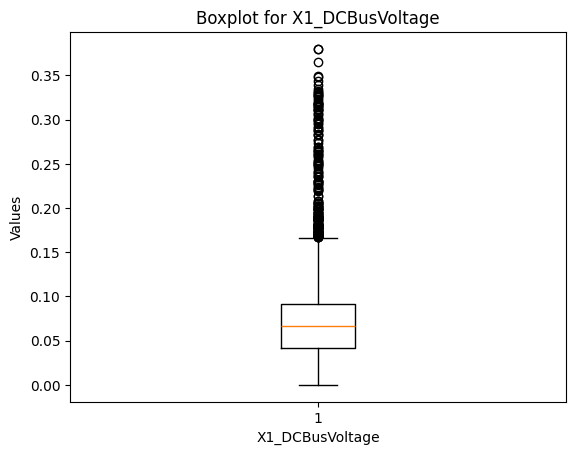

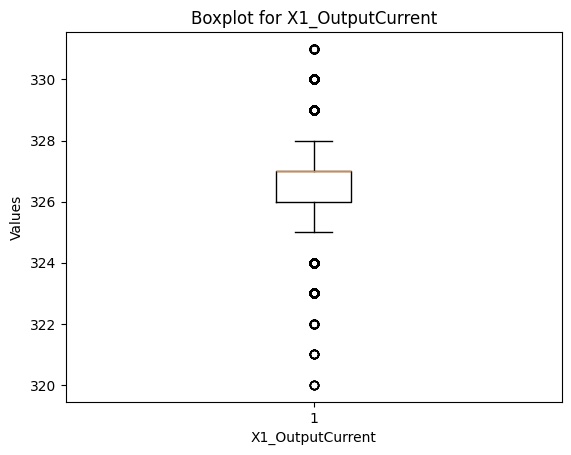

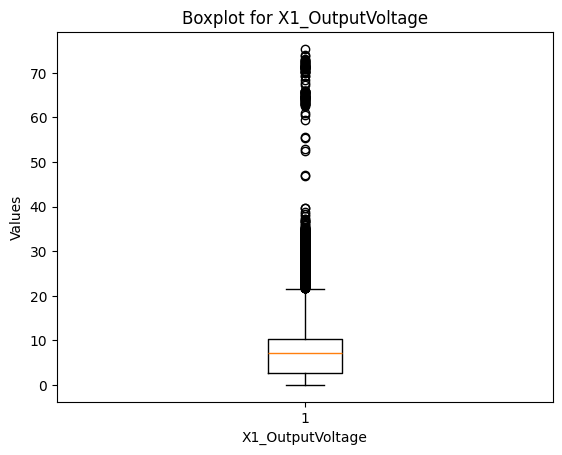

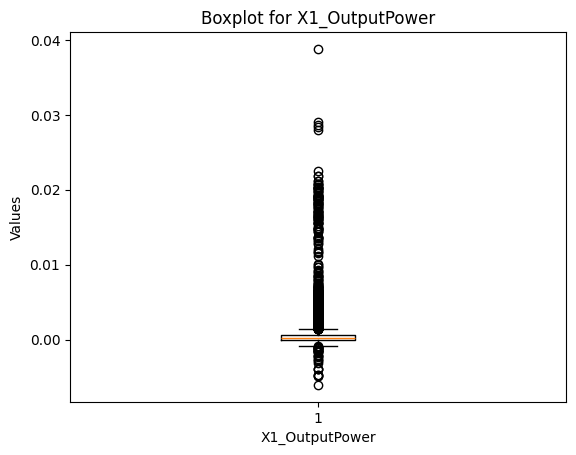

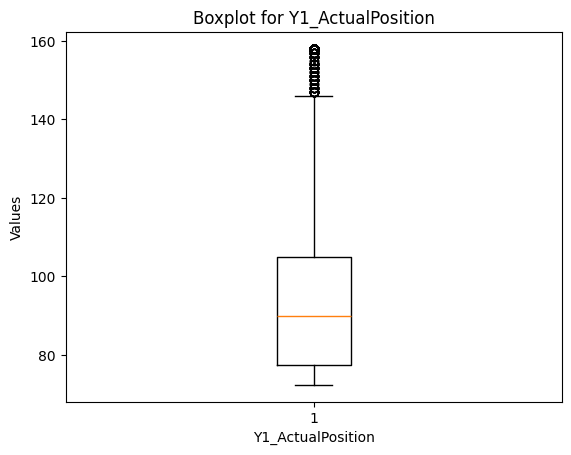

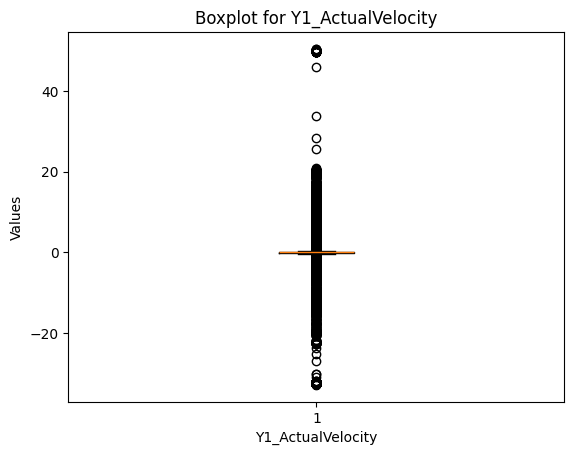

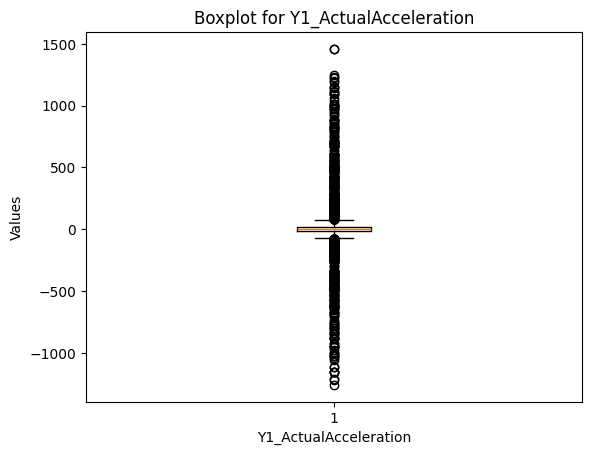

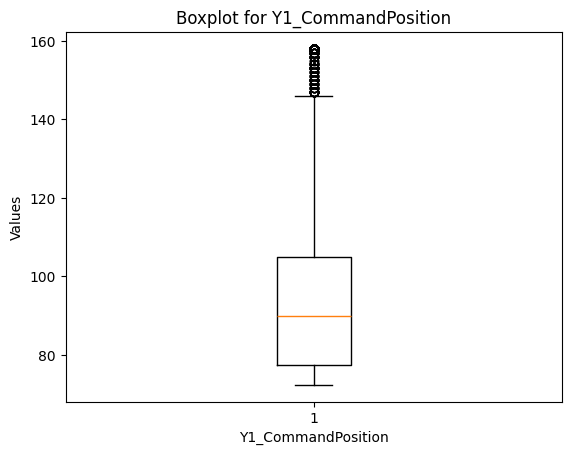

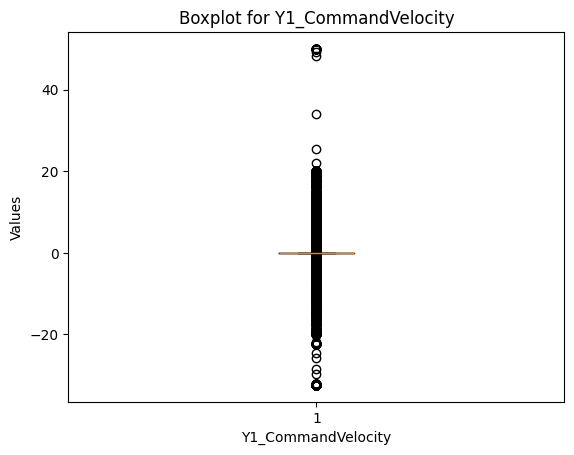

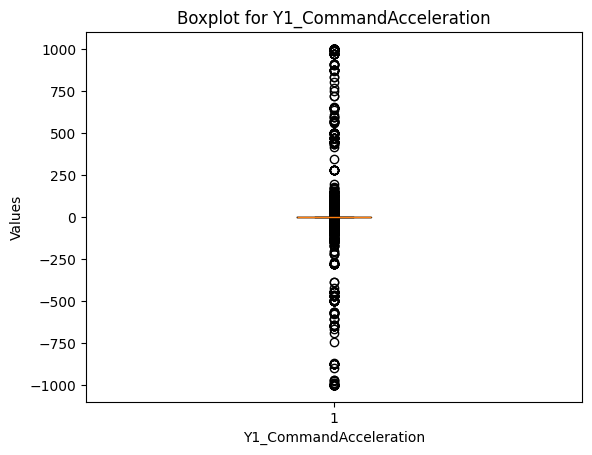

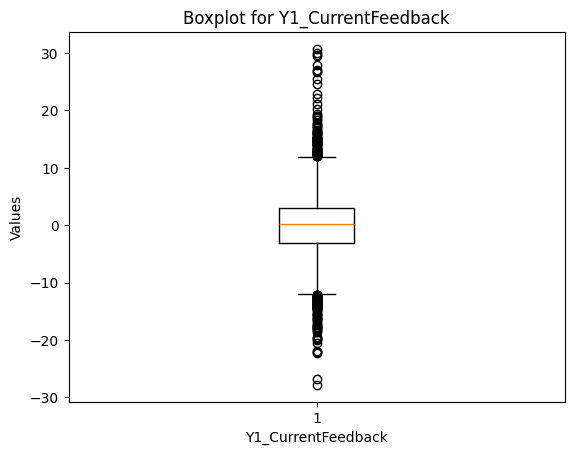

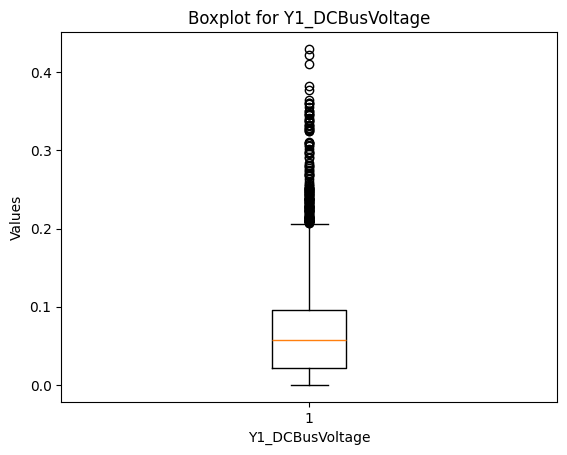

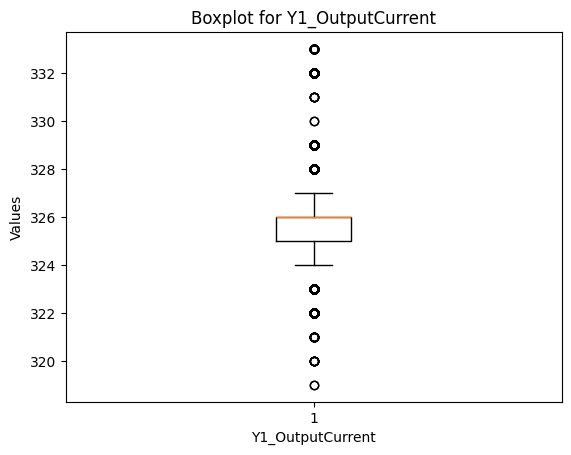

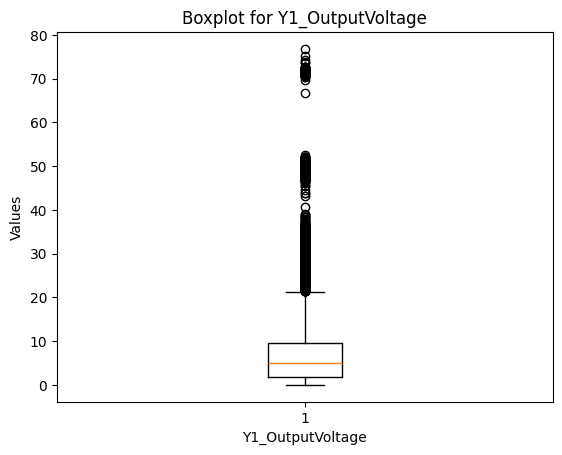

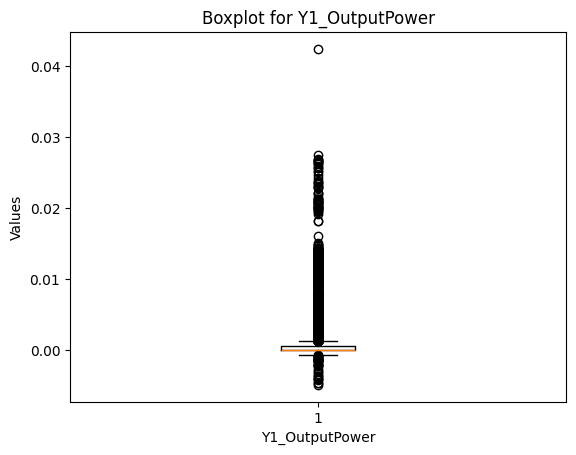

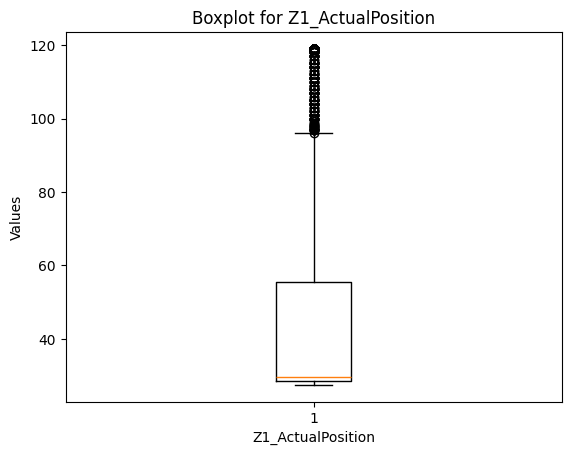

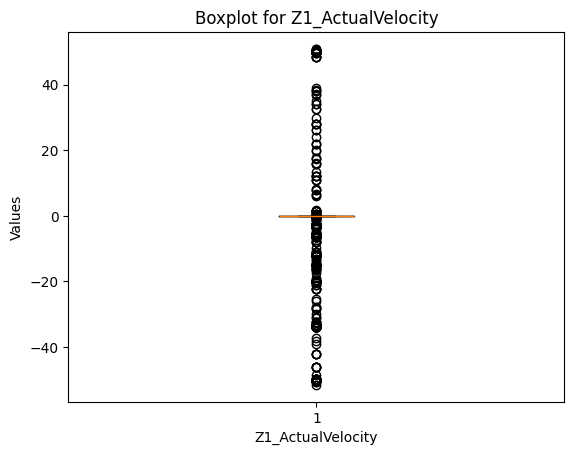

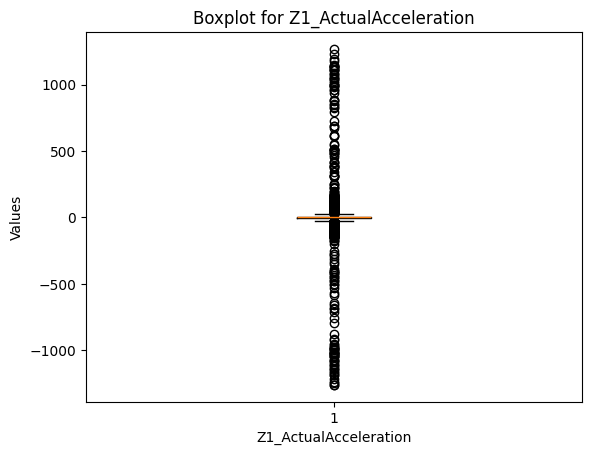

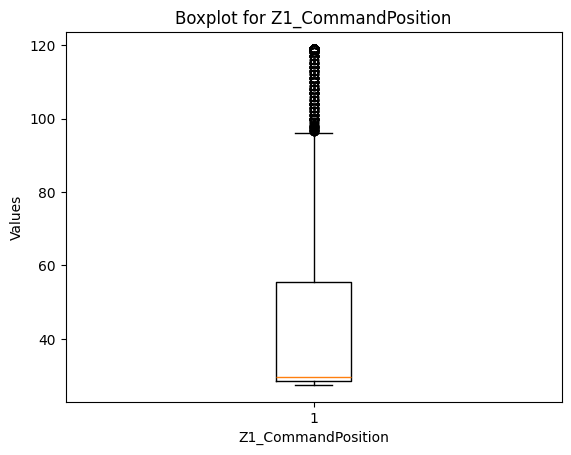

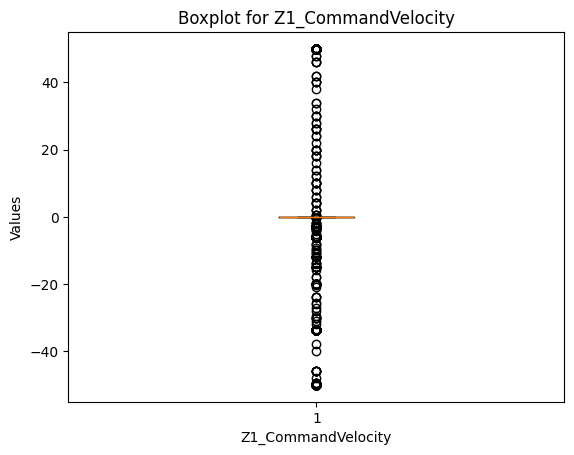

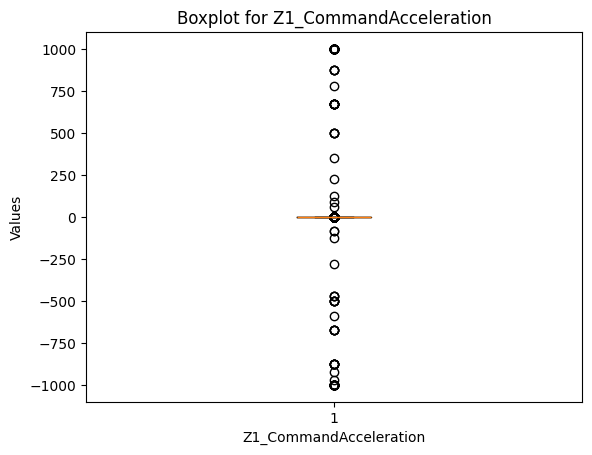

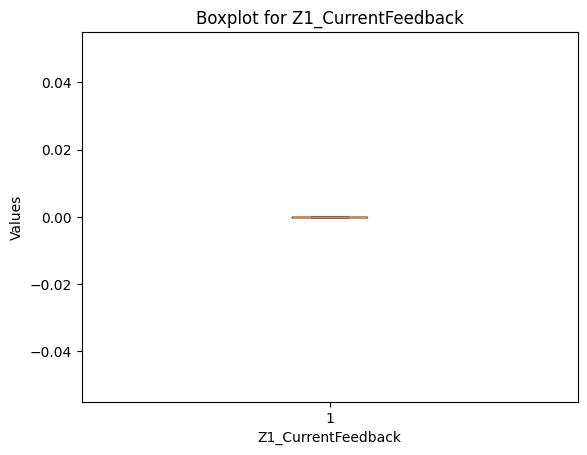

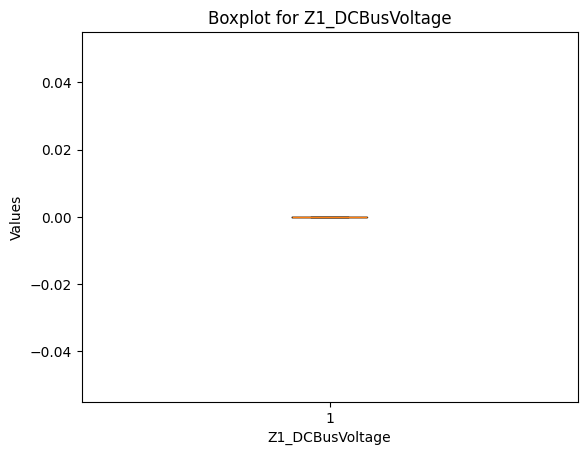

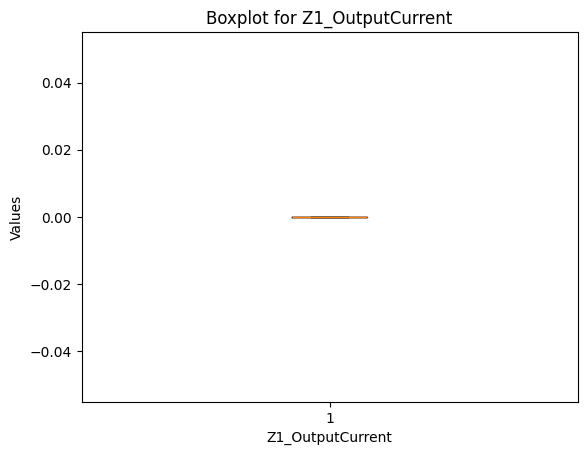

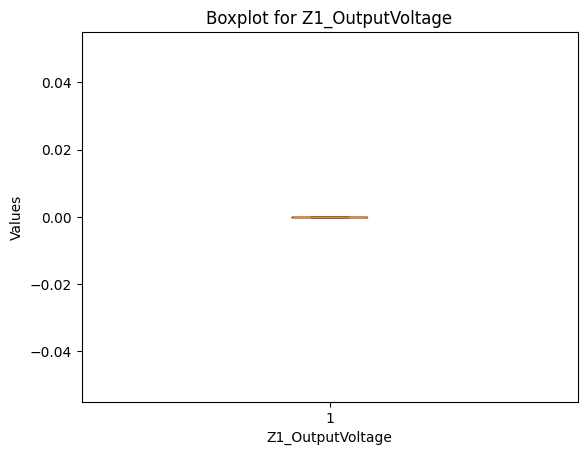

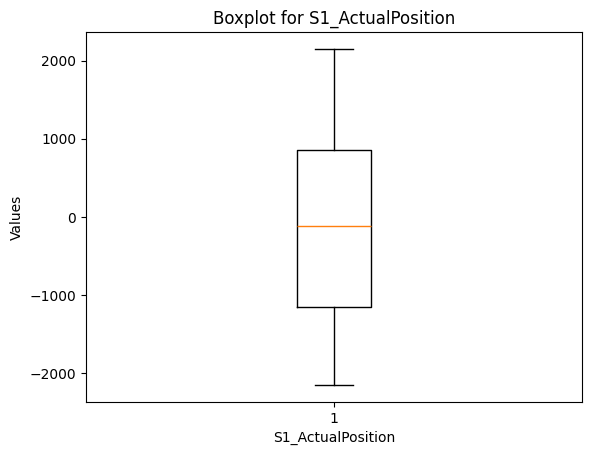

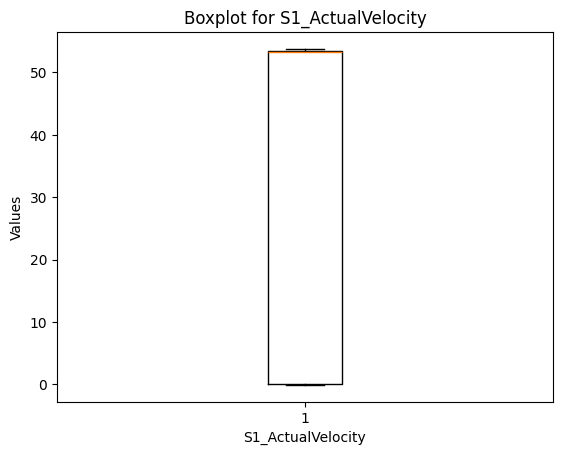

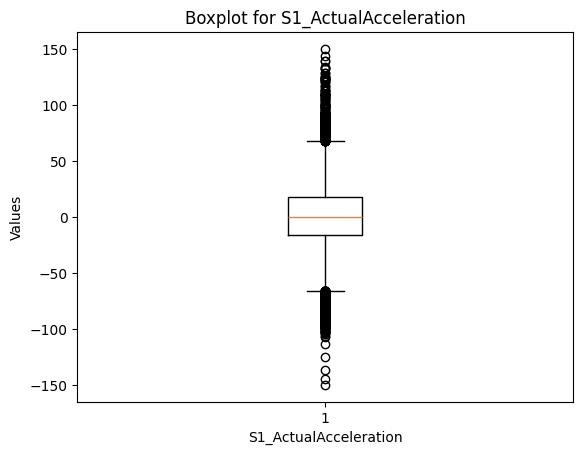

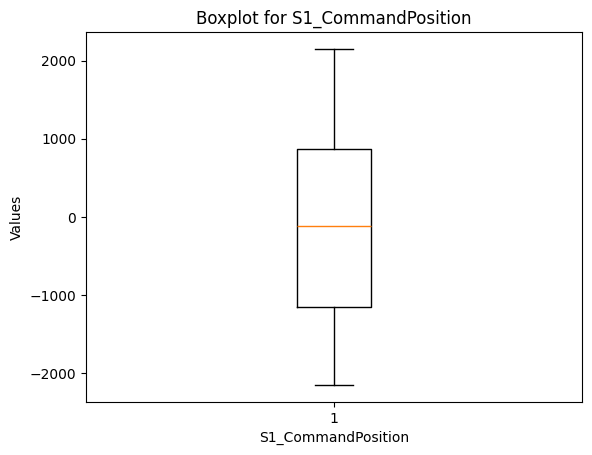

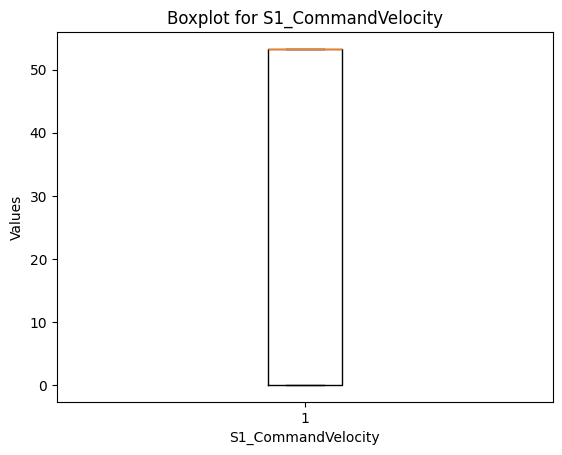

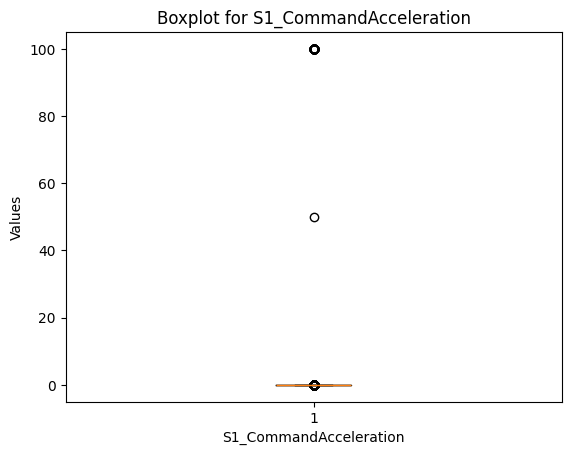

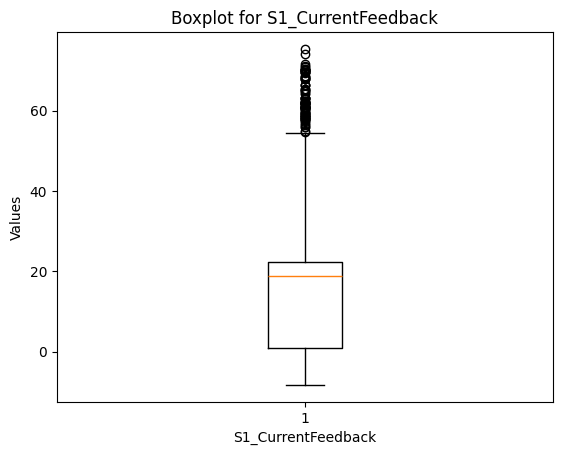

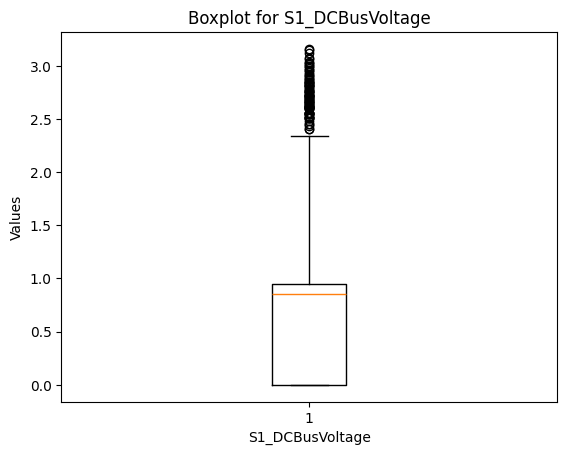

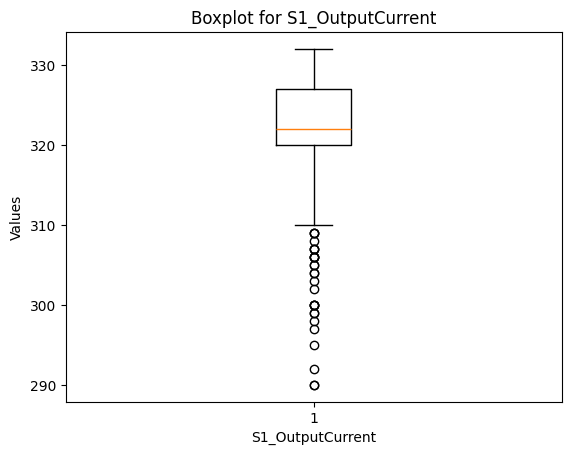

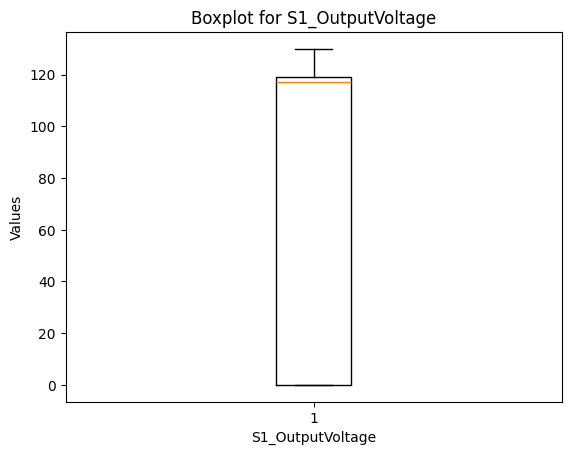

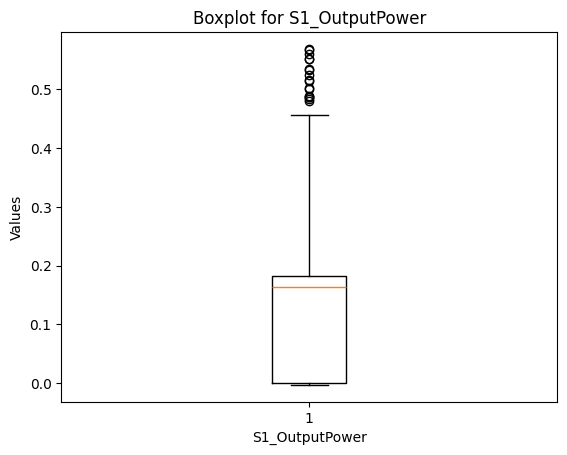

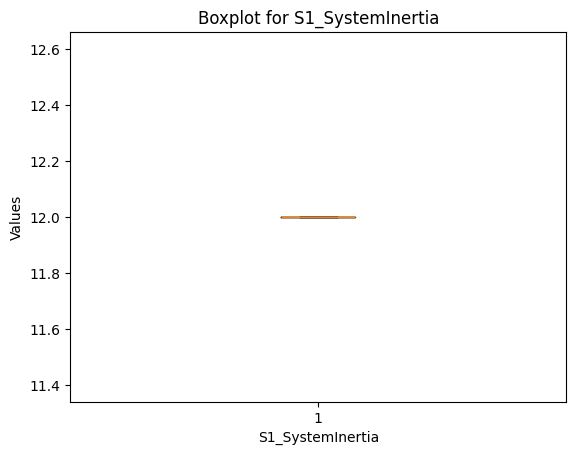

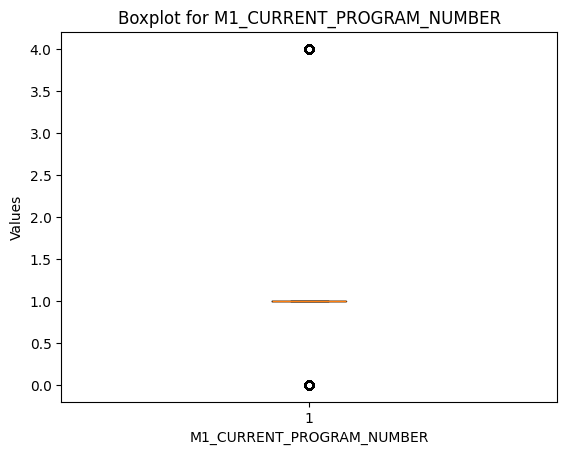

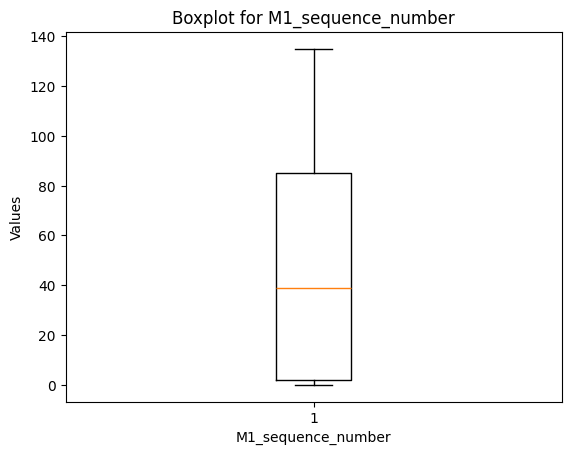

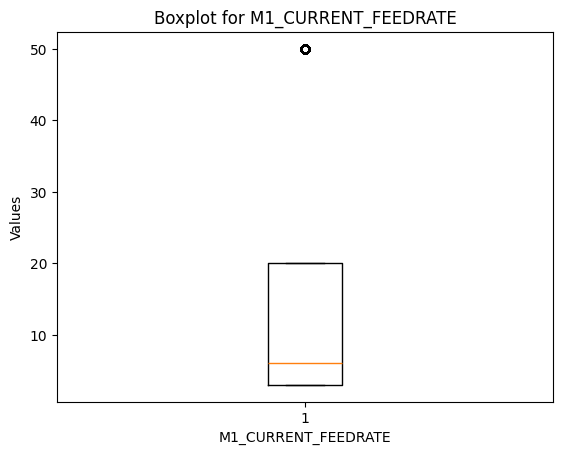

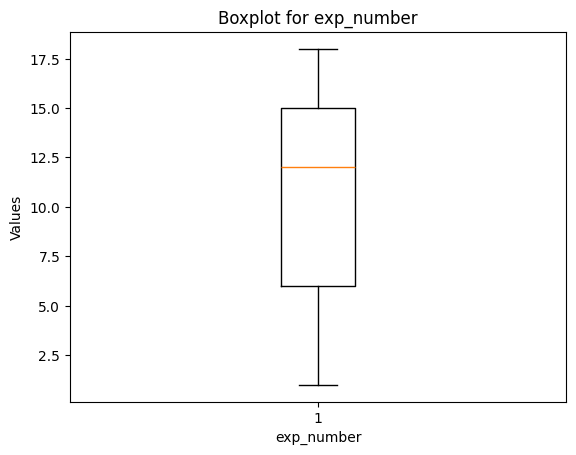

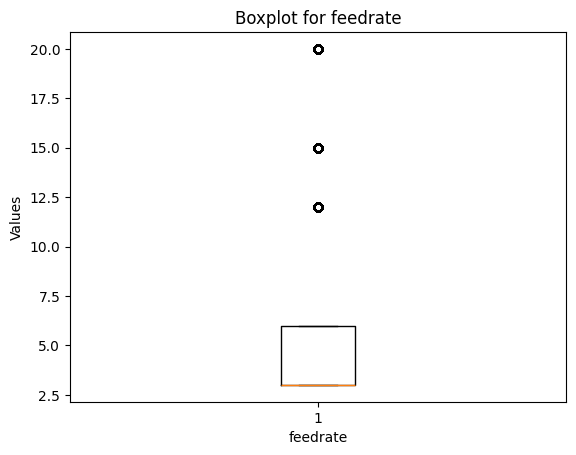

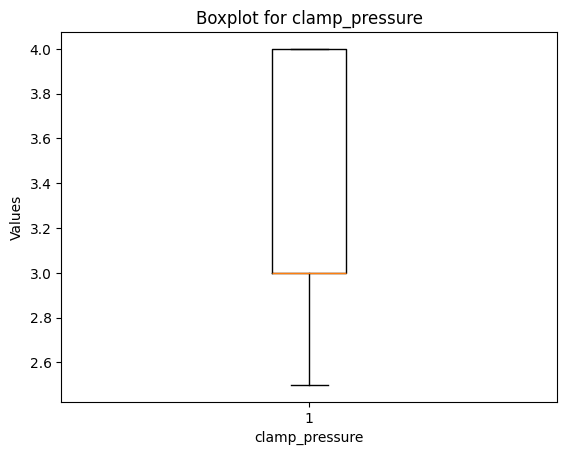

In [14]:
df = merged_data.select_dtypes(exclude=['object'])
'''
for i in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    axes[0].boxplot(df[i])
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Values')
    axes[0].set_title(f'Boxplot for {i}')

    df[i].plot(kind='bar', ax=axes[1])
    axes[1].set_xlabel(i)
    axes[1].set_ylabel('Values')
    axes[1].set_title(f'Boxplot for {i}')

    sns.scatterplot(df[i], ax=axes[2])
    axes[2].set_xlabel(i)
    axes[2].set_ylabel('Values')
    axes[2].set_title(f'Scatter for {i}')
plt.show()
'''
for i in df.columns:
    plt.boxplot(df[i])
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.title(f'Boxplot for {i}')
    plt.show()

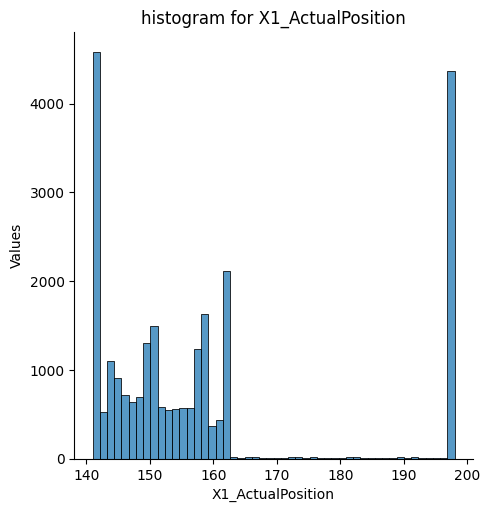

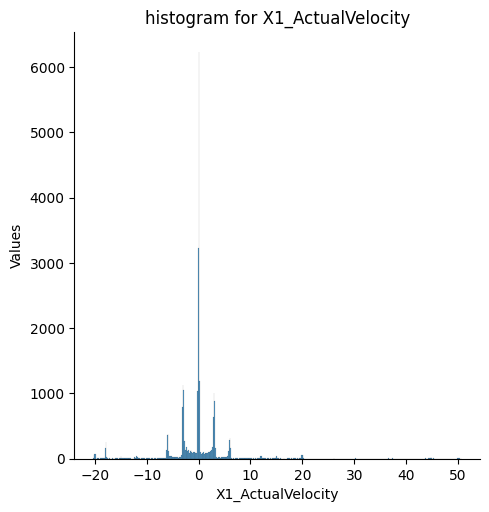

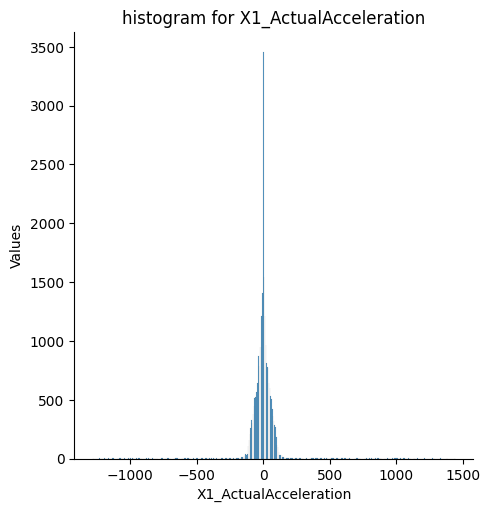

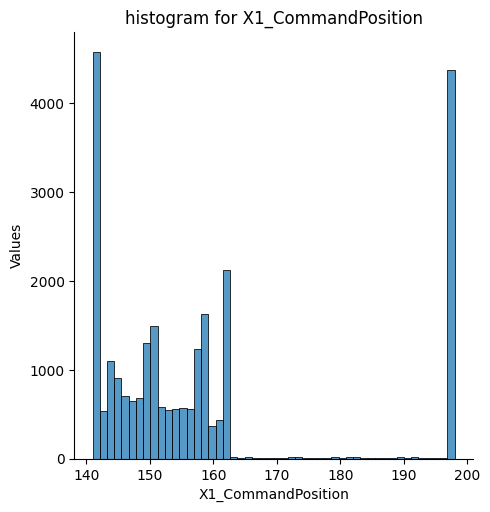

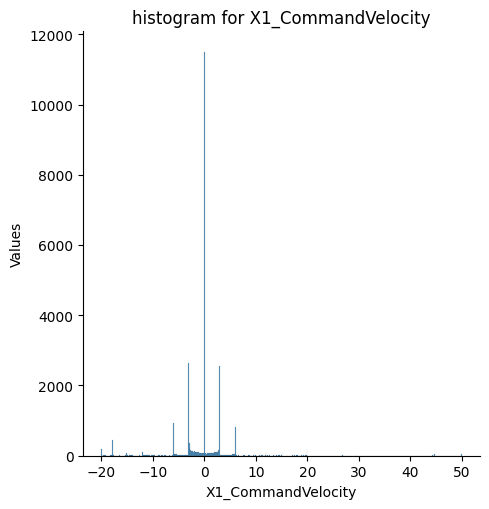

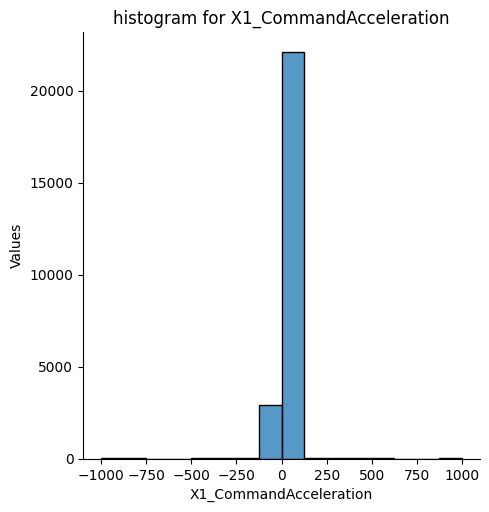

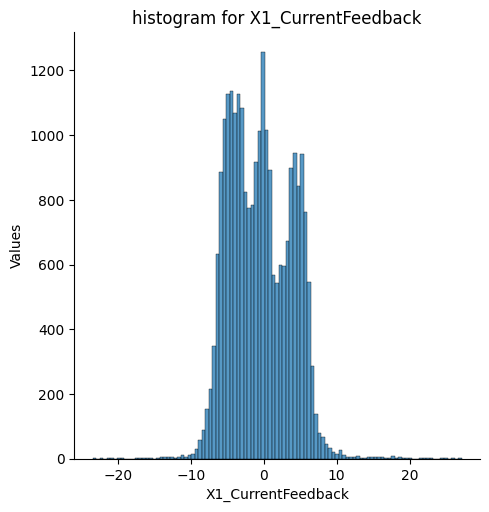

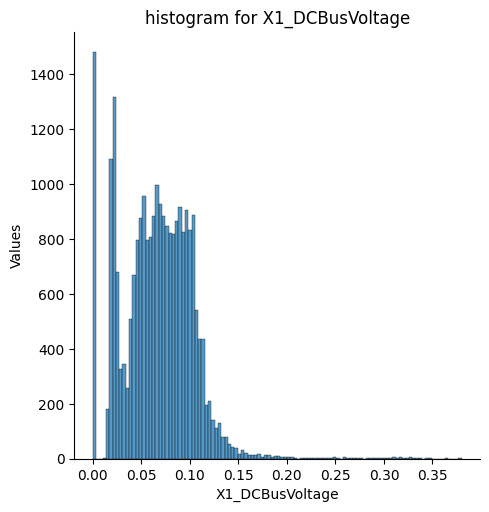

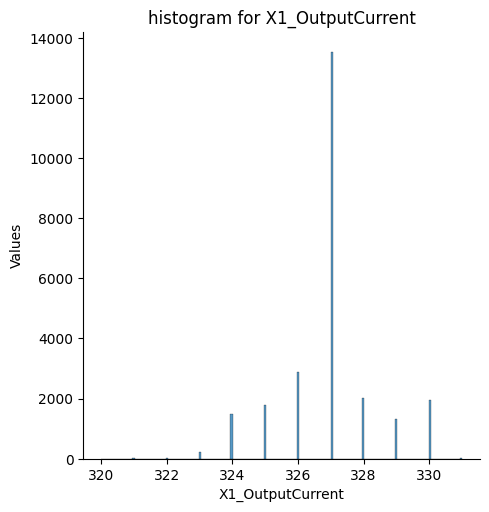

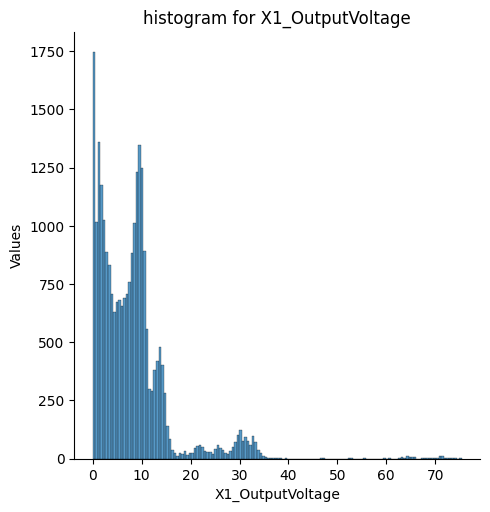

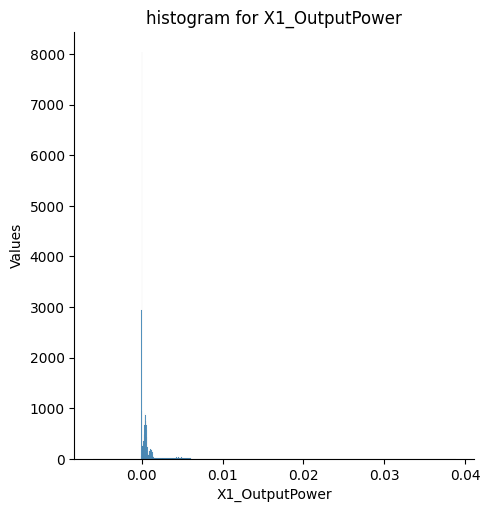

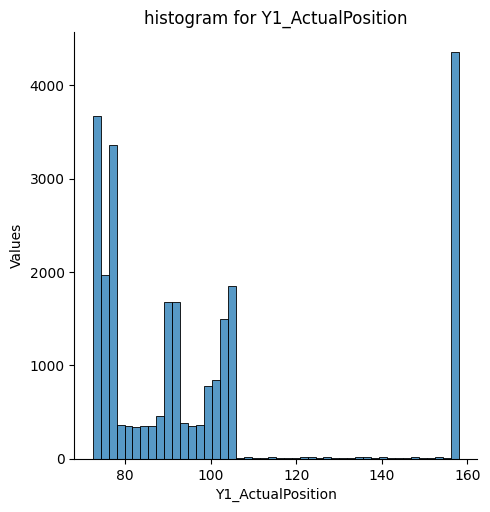

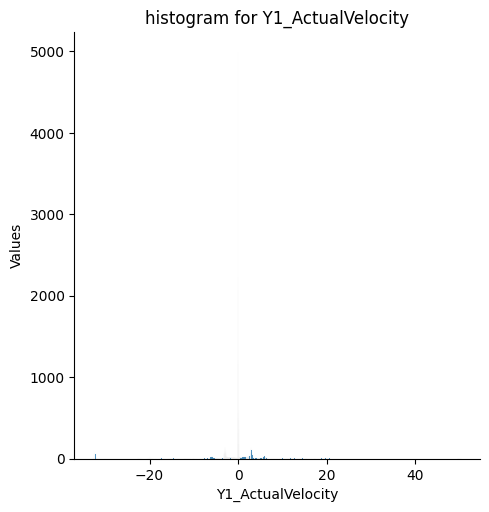

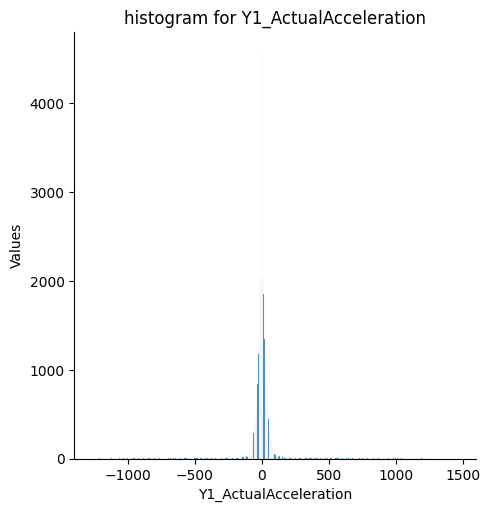

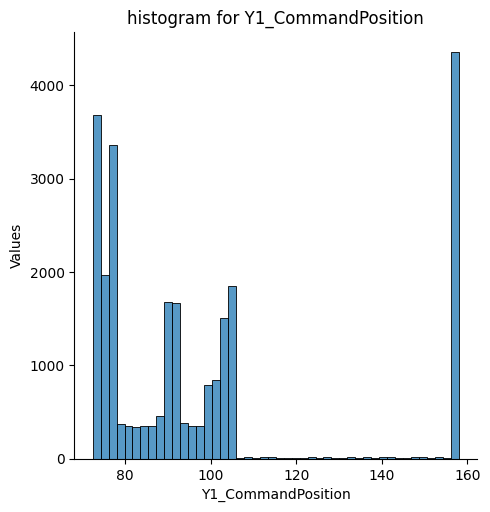

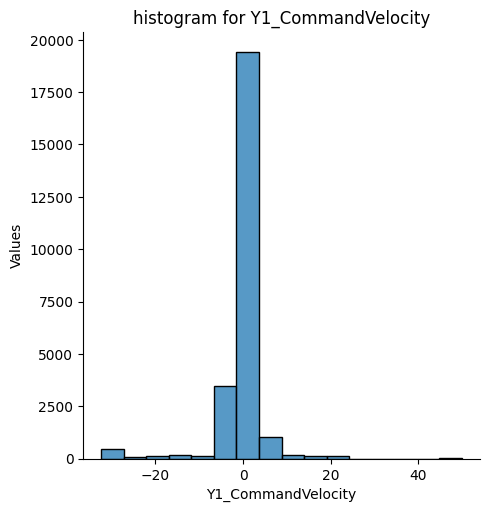

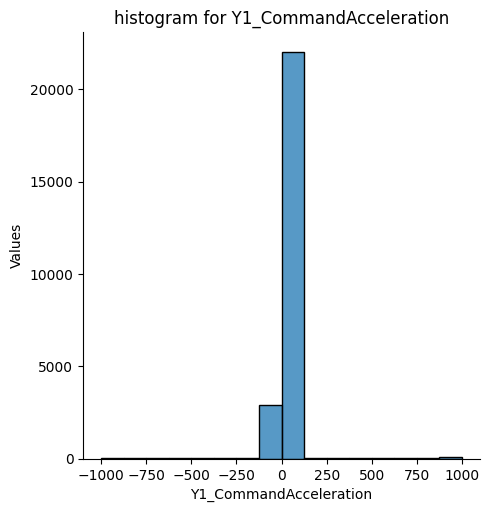

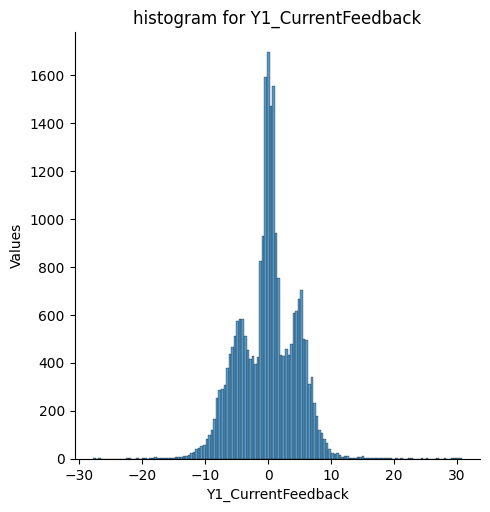

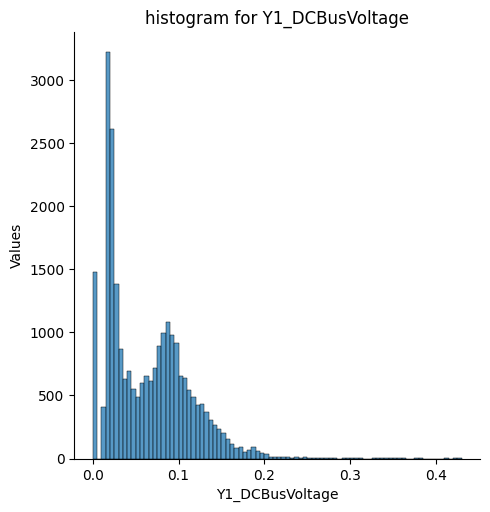

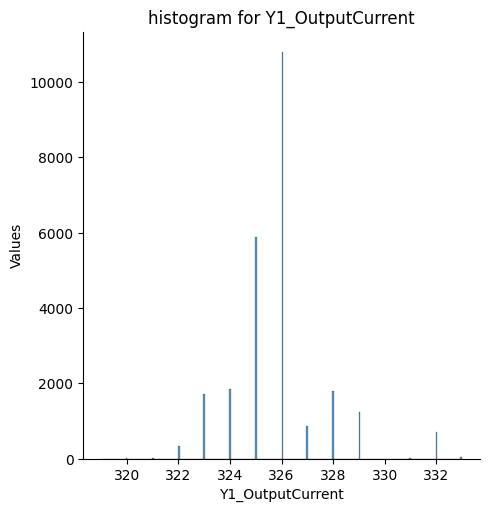

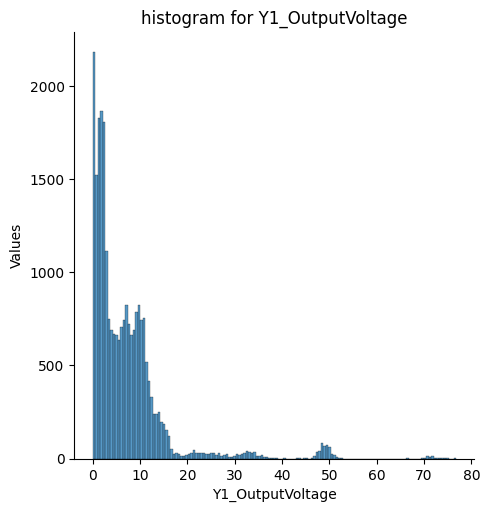

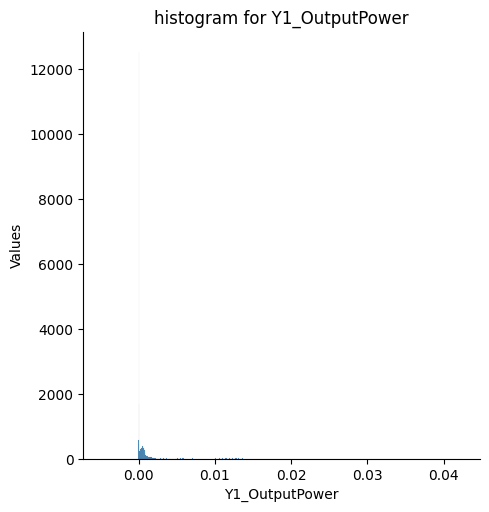

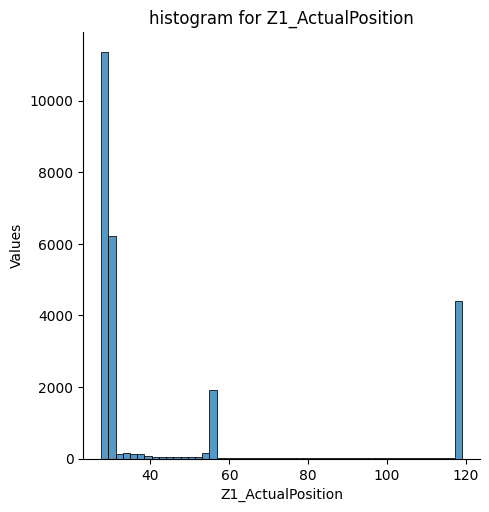

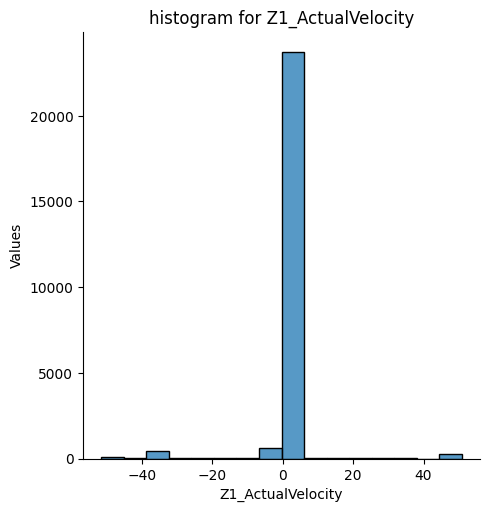

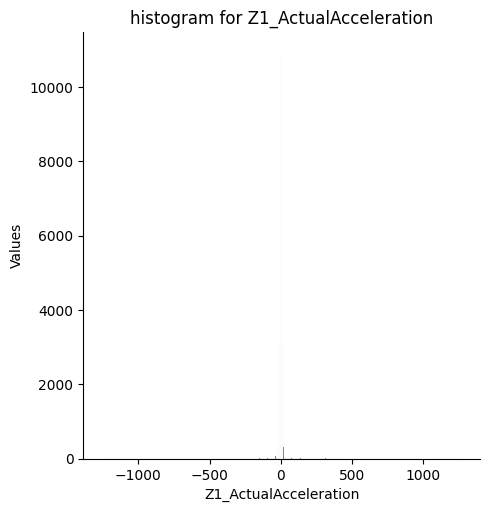

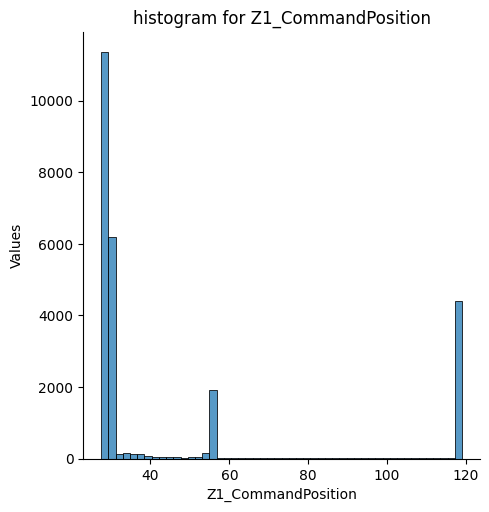

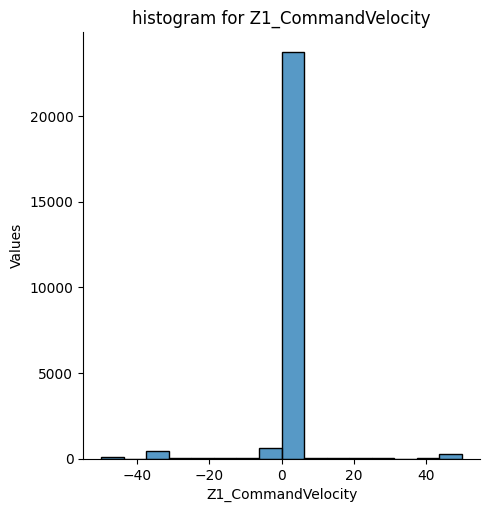

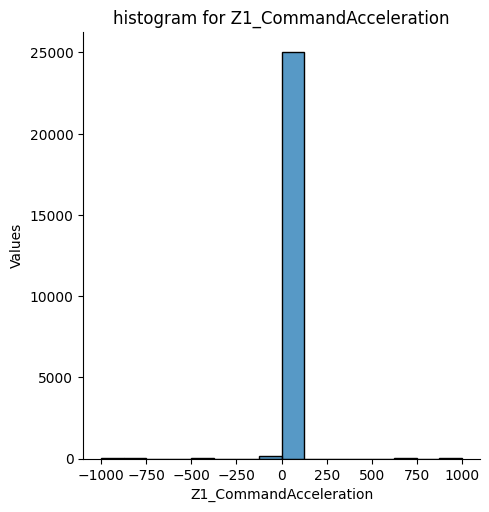

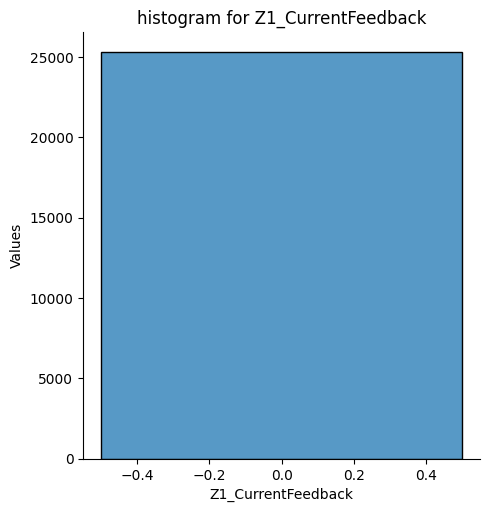

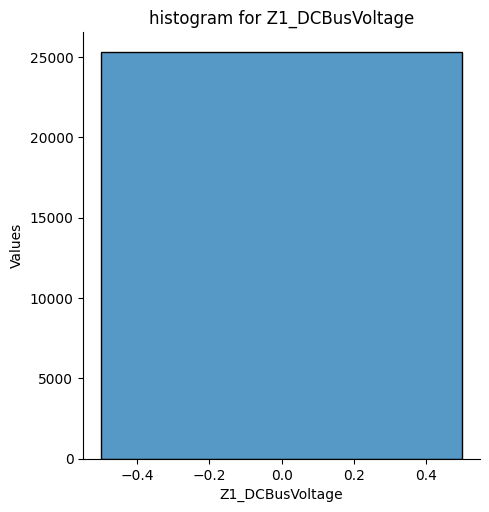

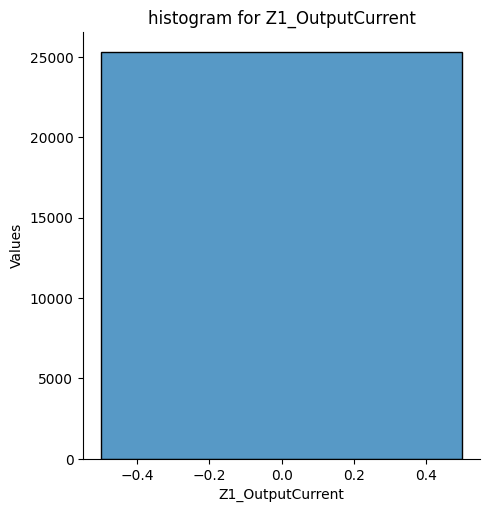

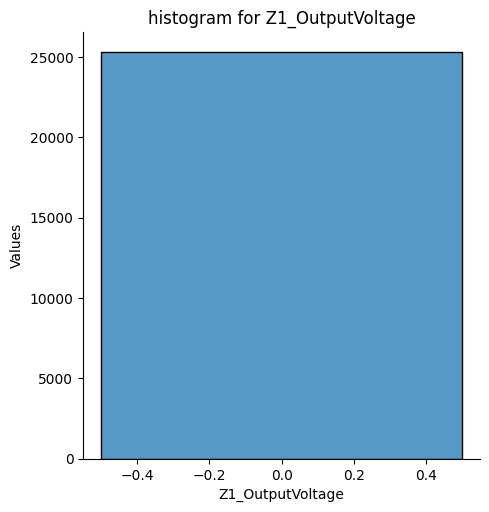

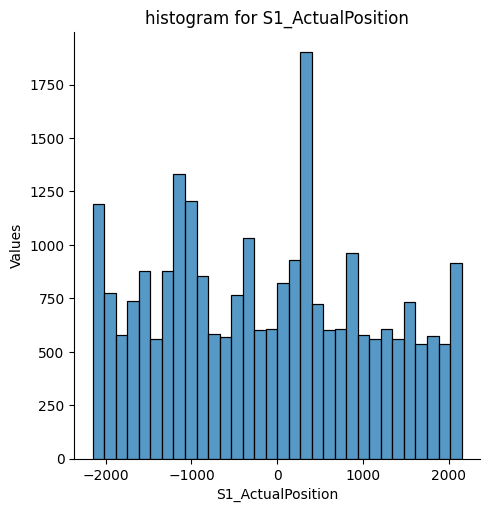

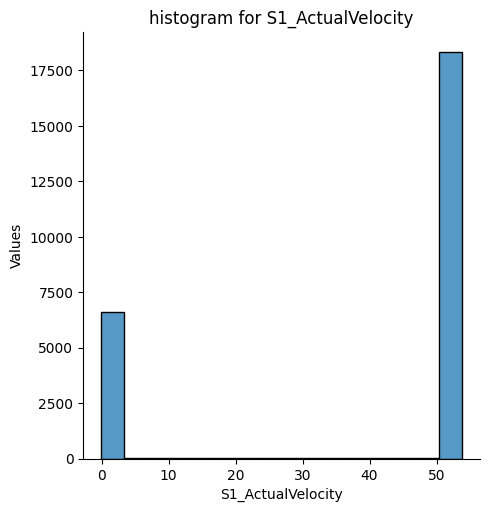

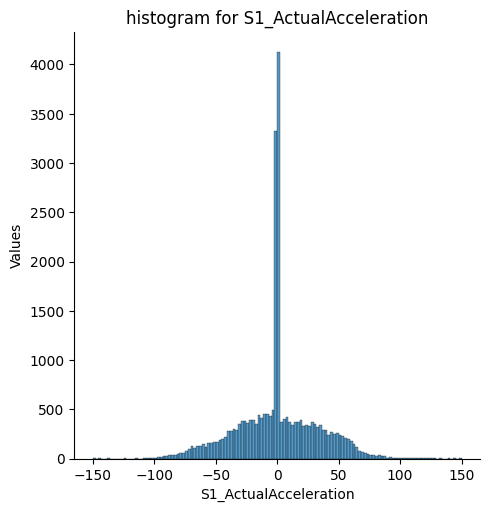

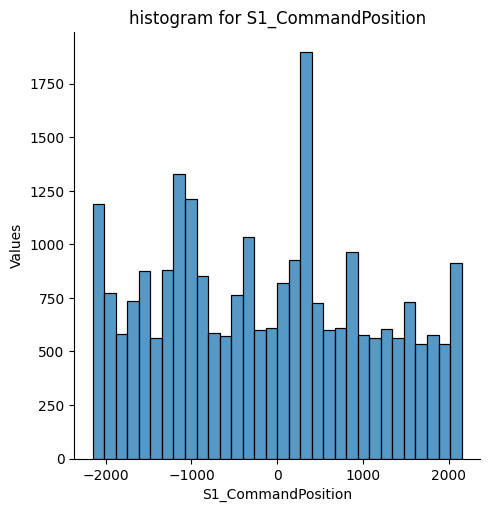

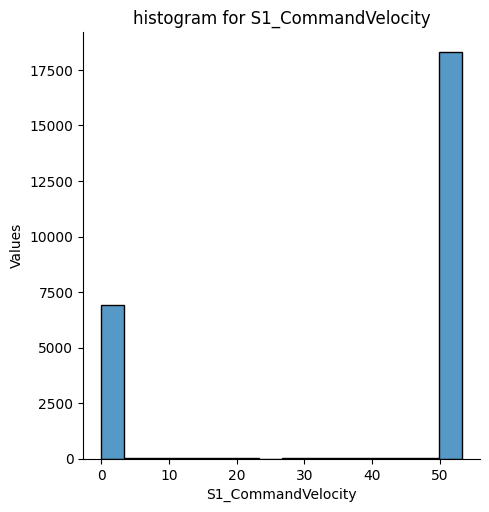

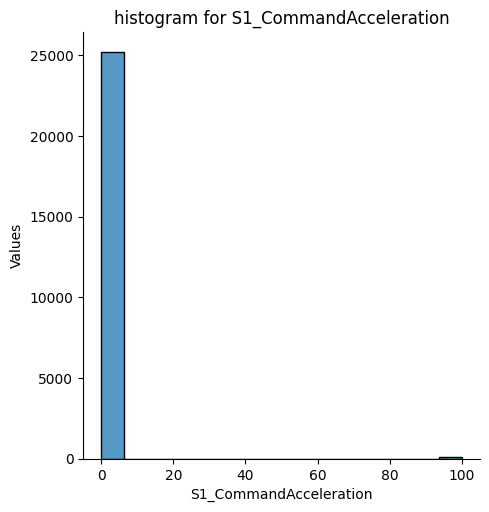

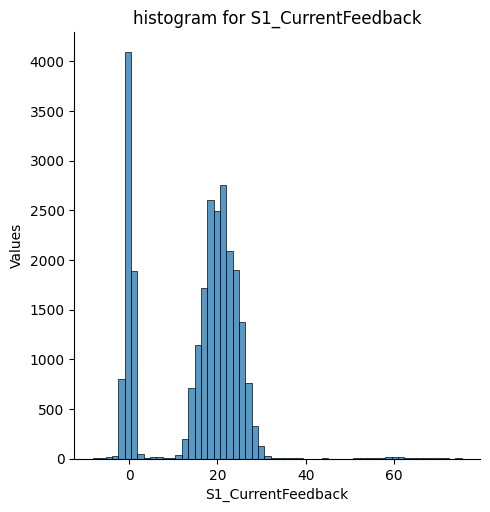

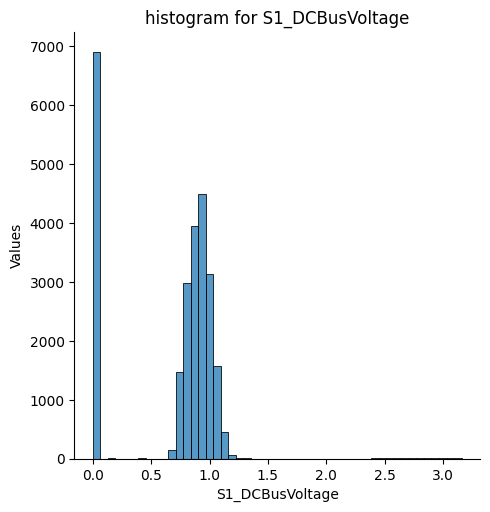

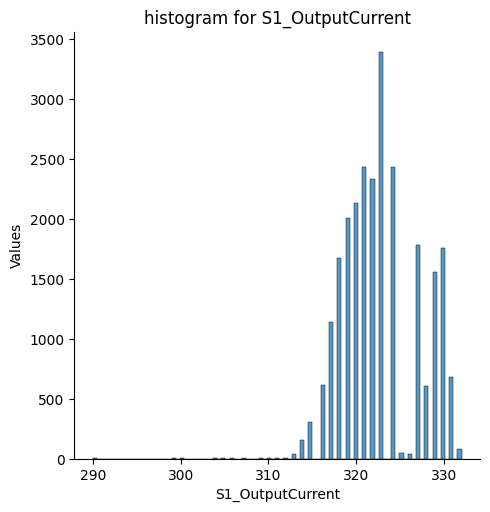

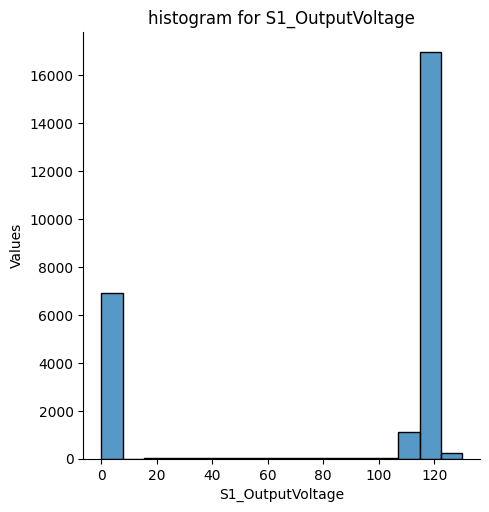

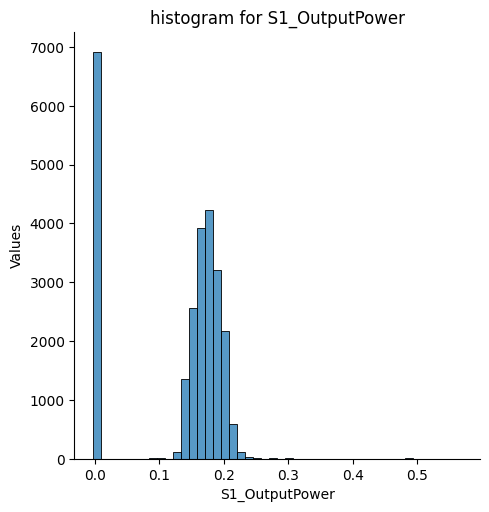

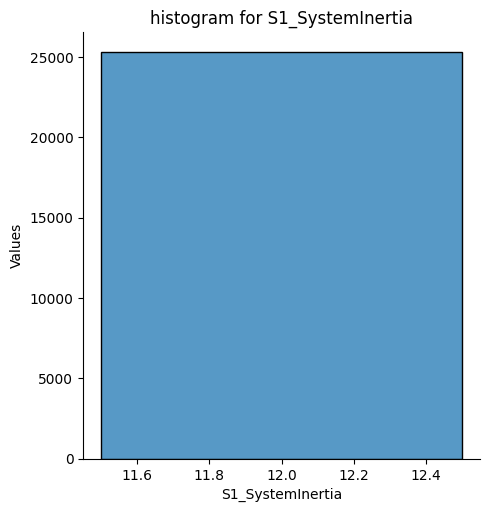

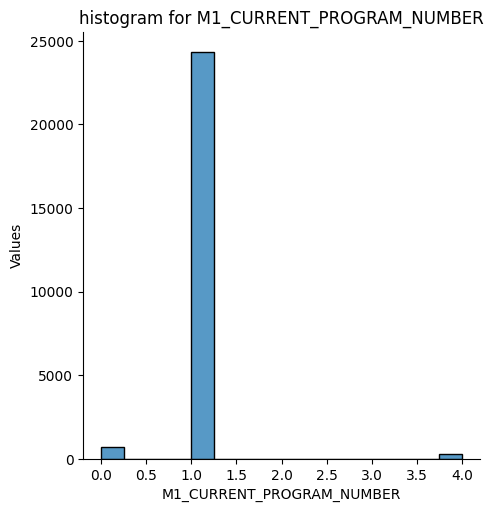

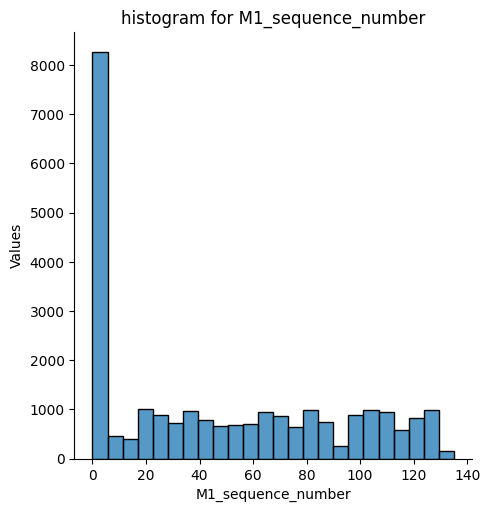

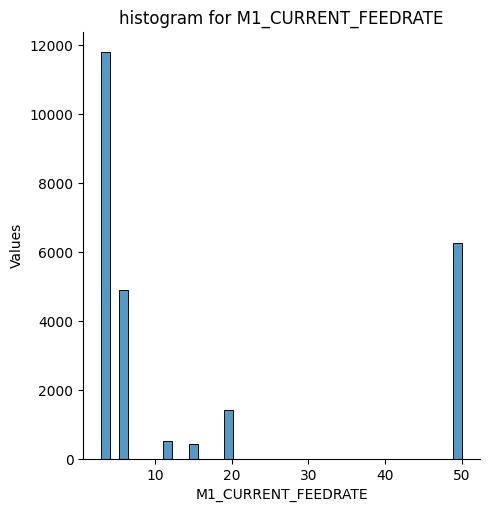

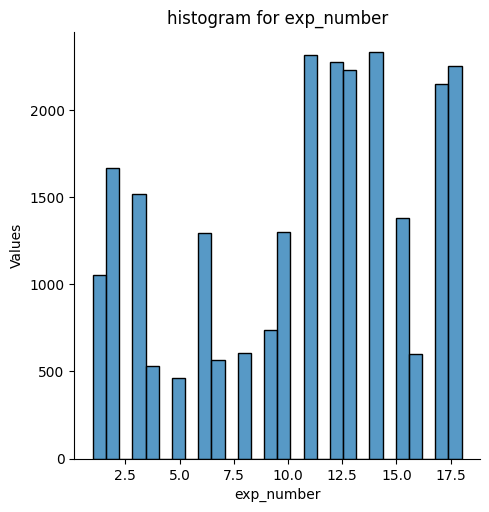

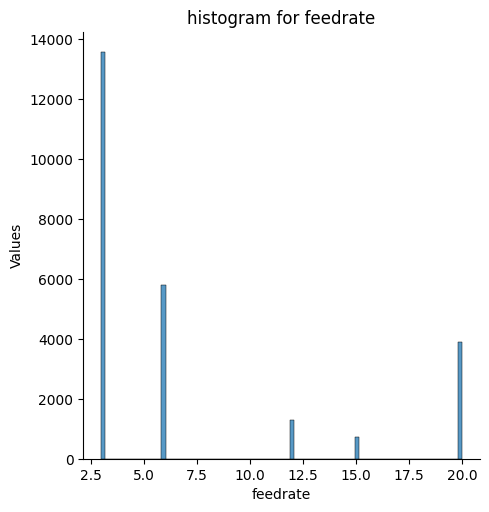

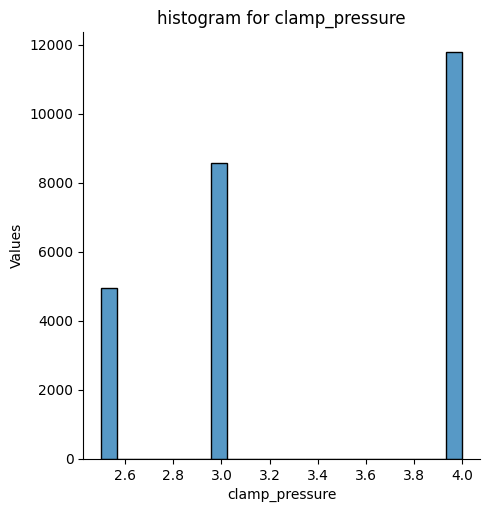

In [15]:
for i in df.columns:
    sns.displot(df[i])
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.title(f'histogram for {i}')
    plt.show()

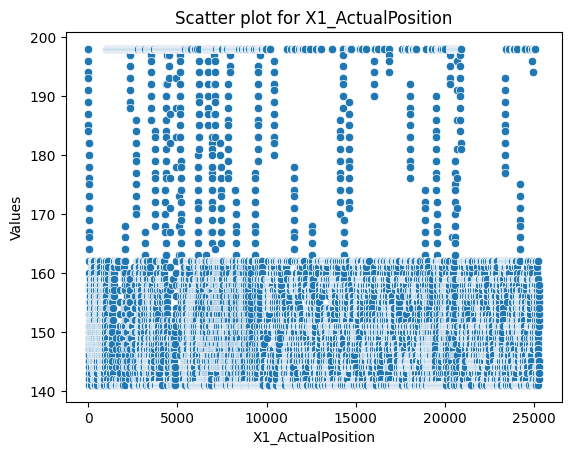

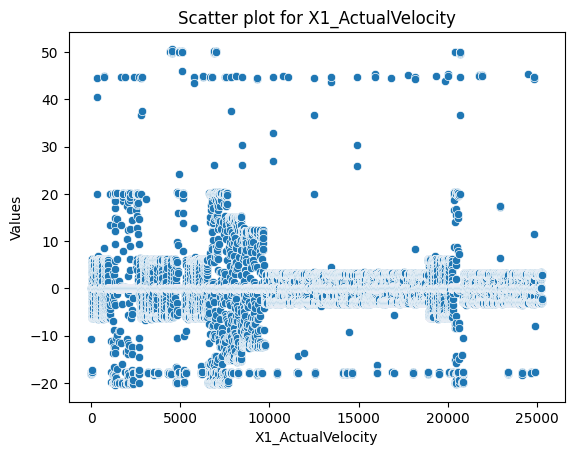

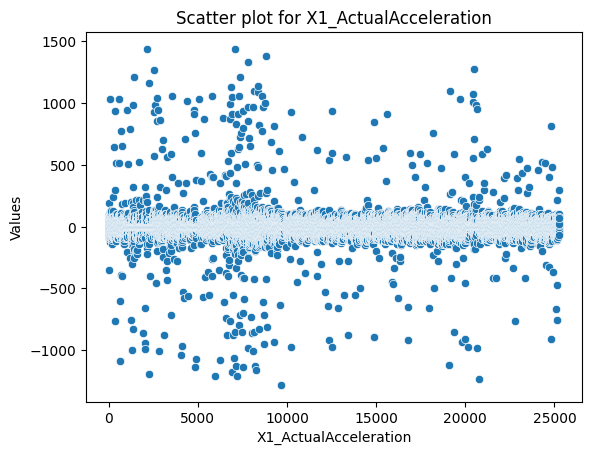

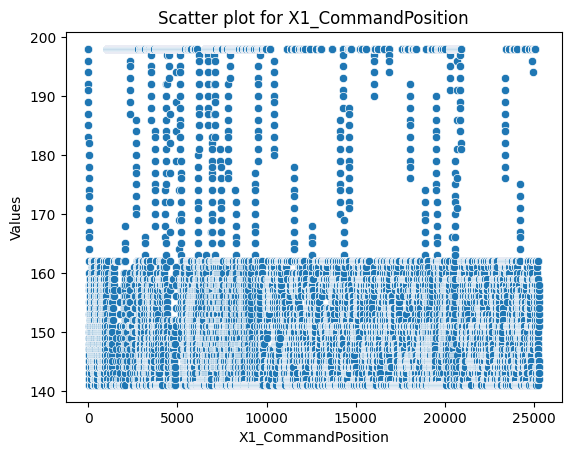

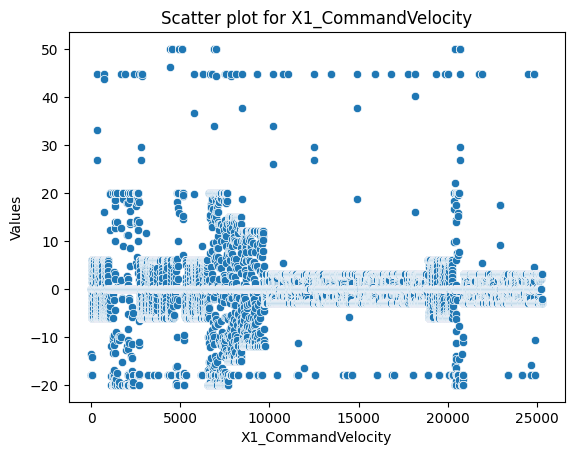

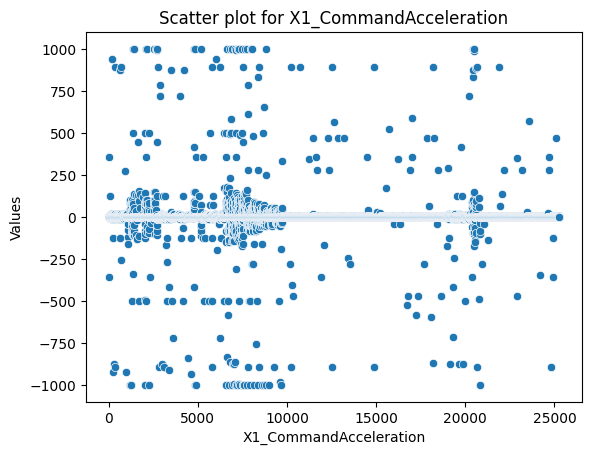

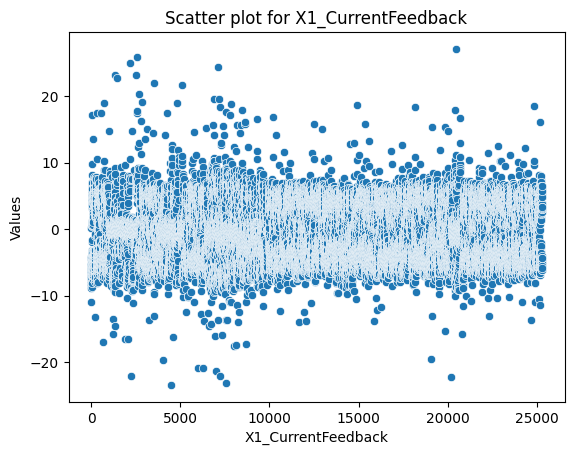

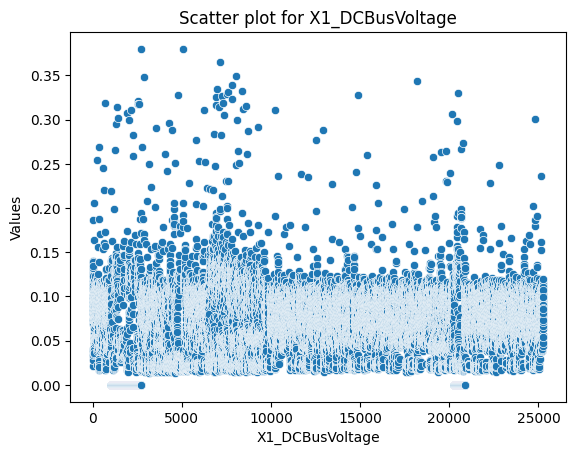

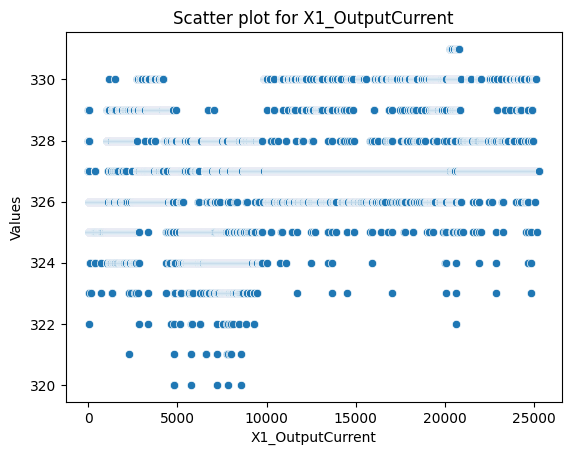

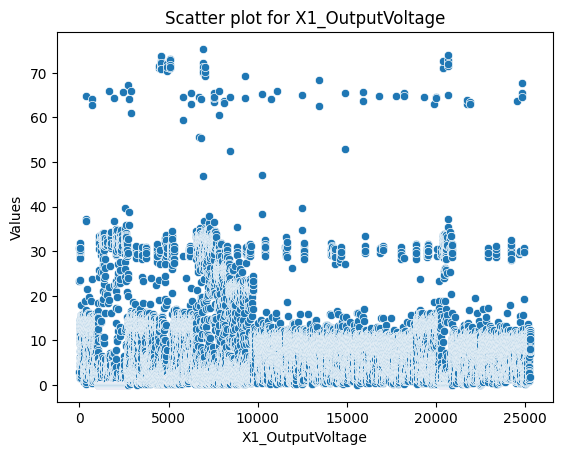

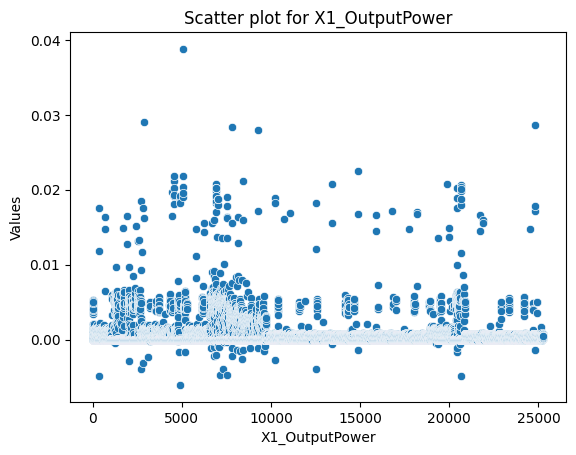

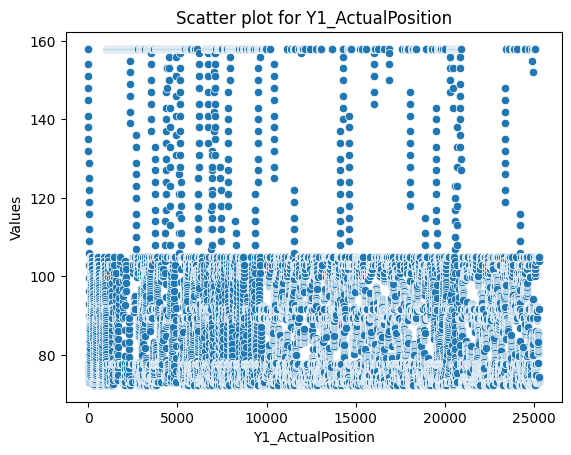

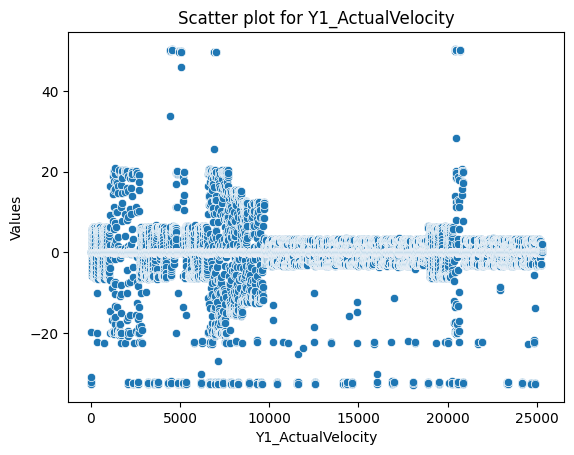

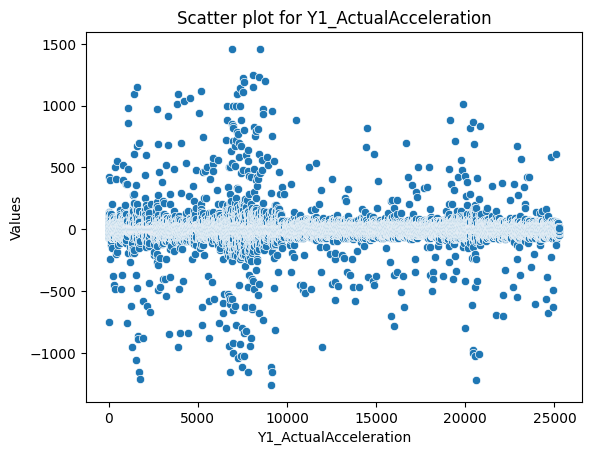

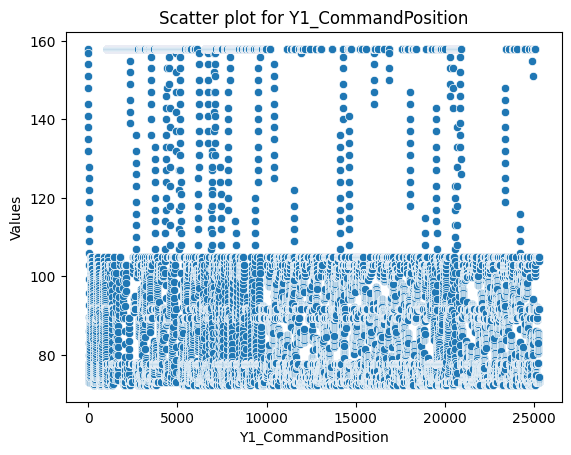

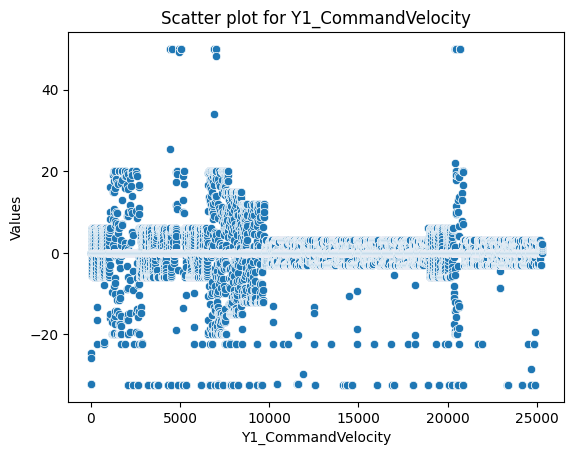

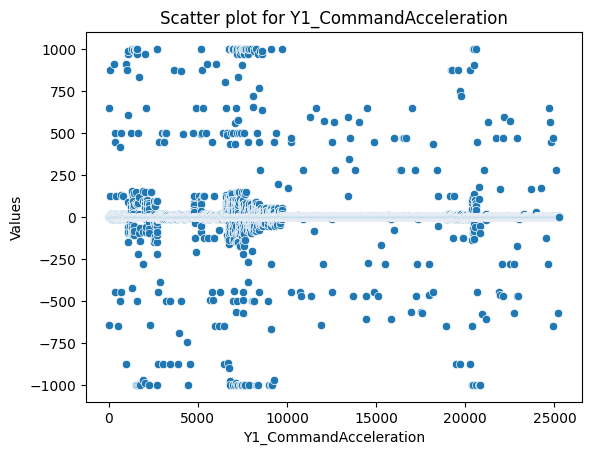

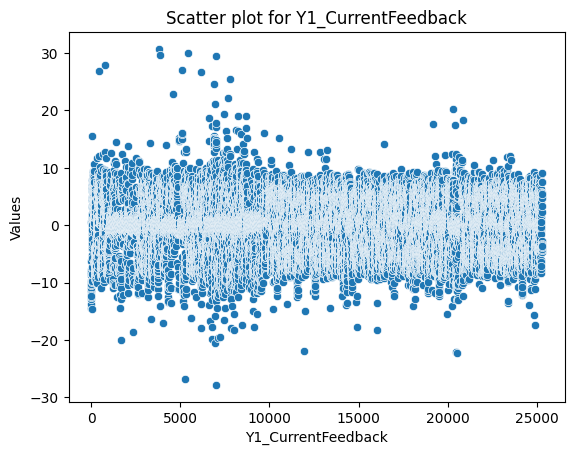

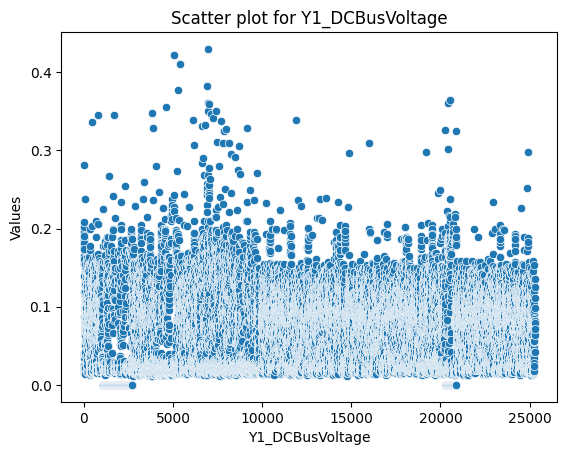

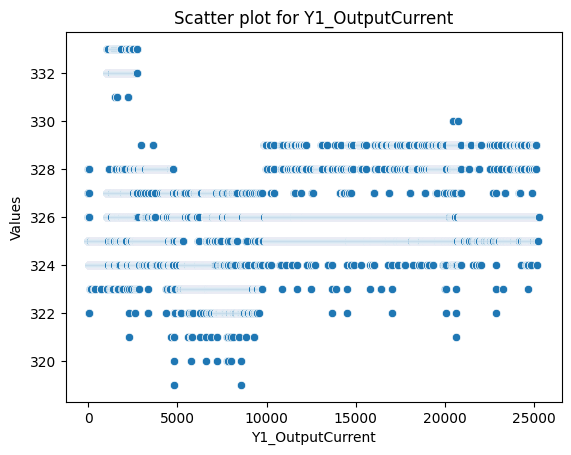

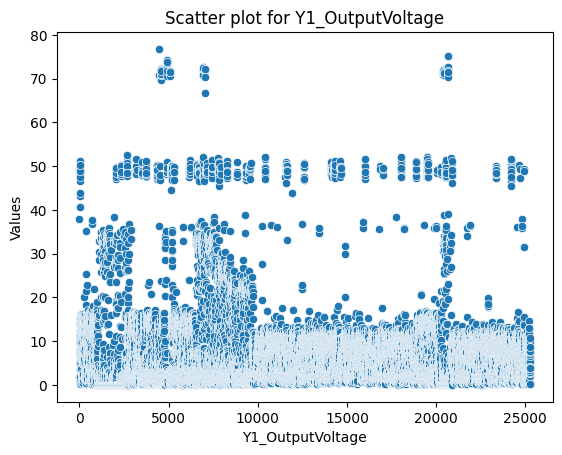

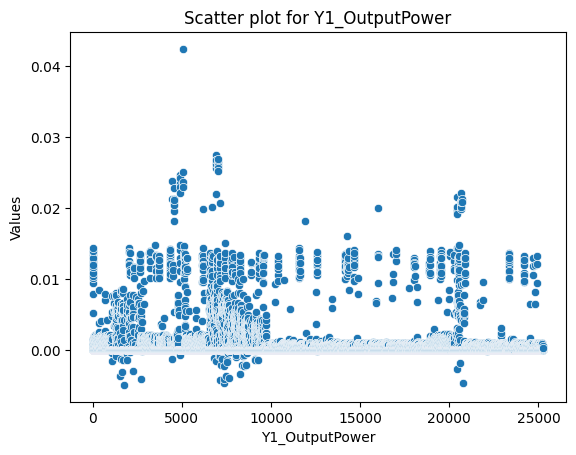

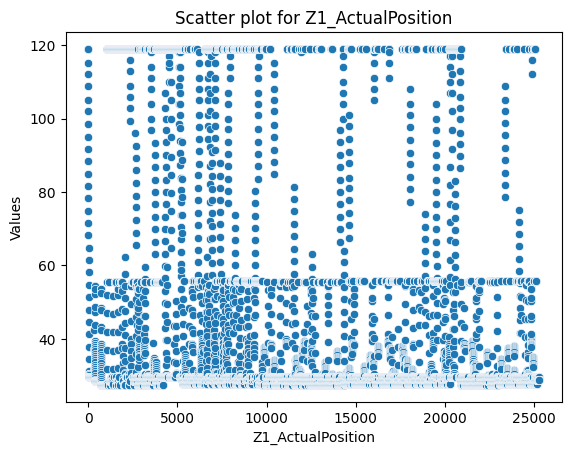

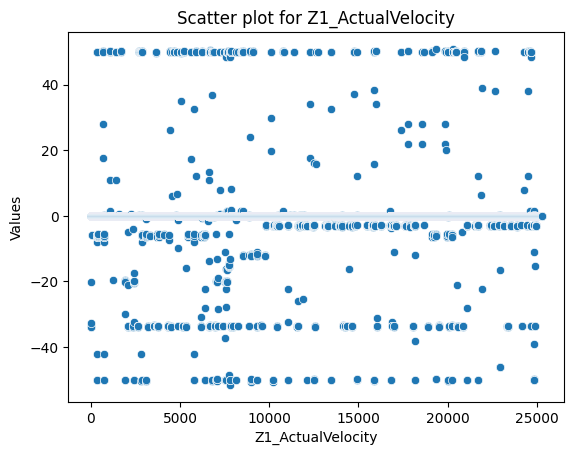

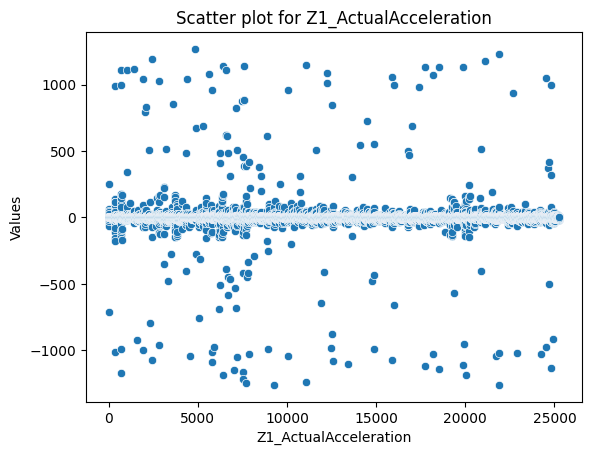

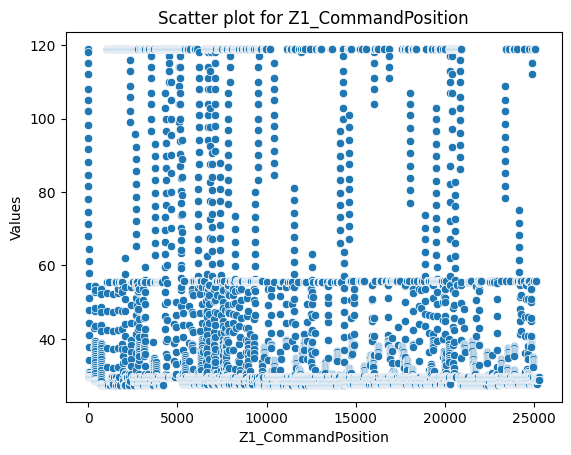

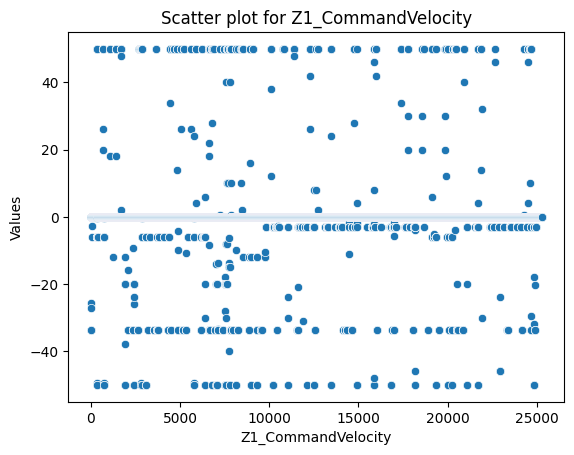

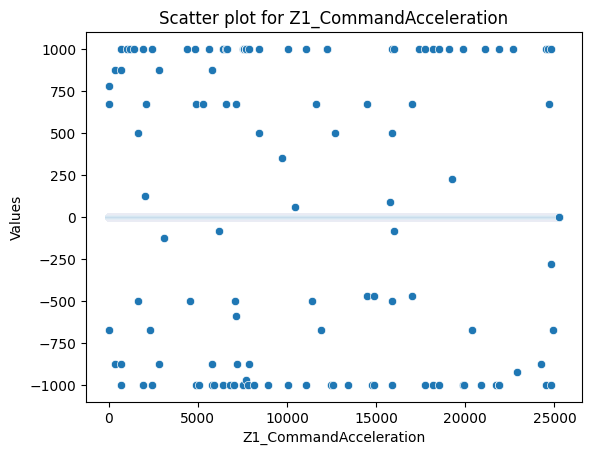

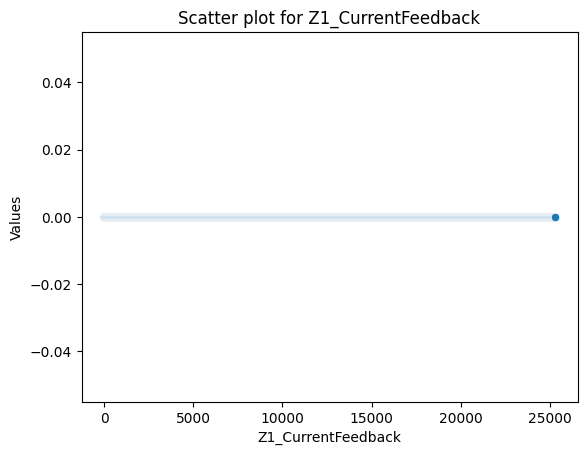

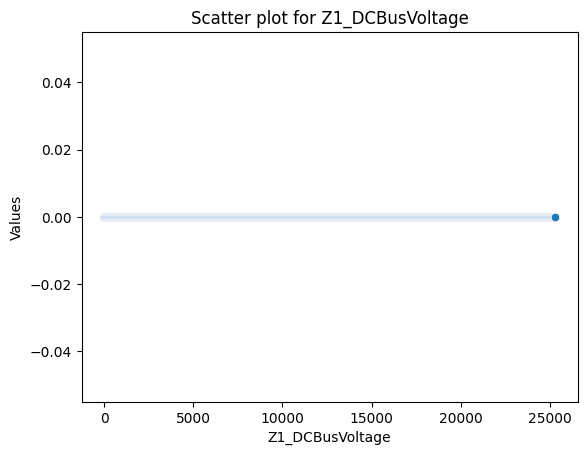

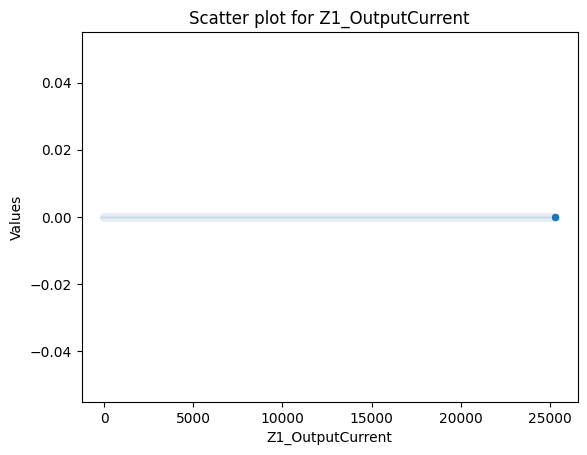

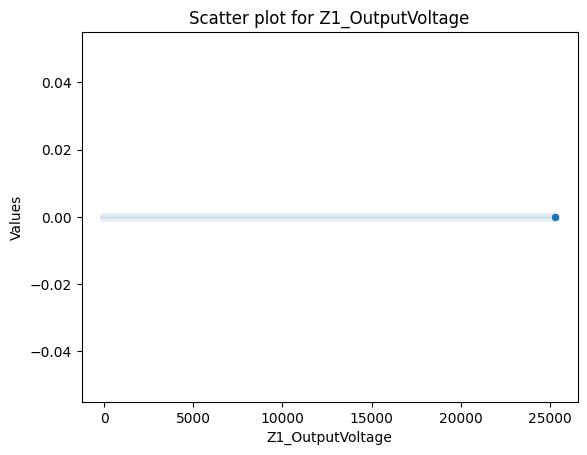

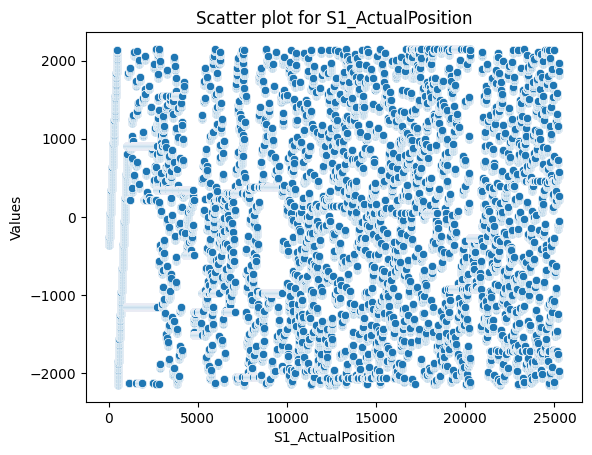

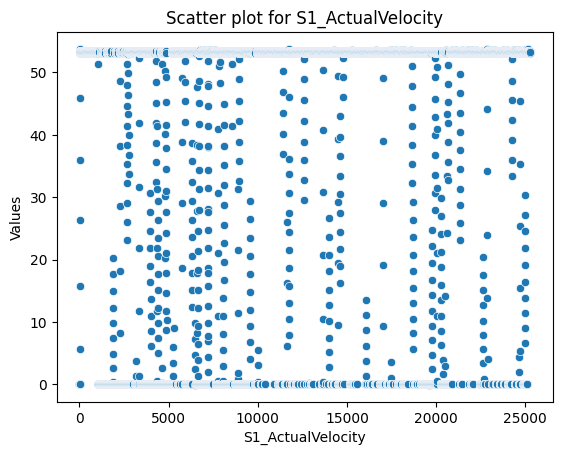

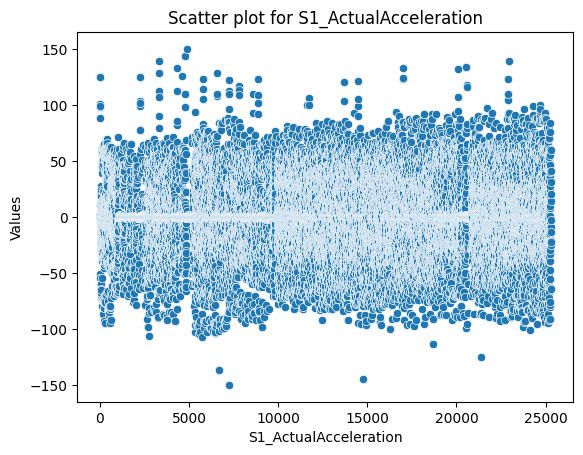

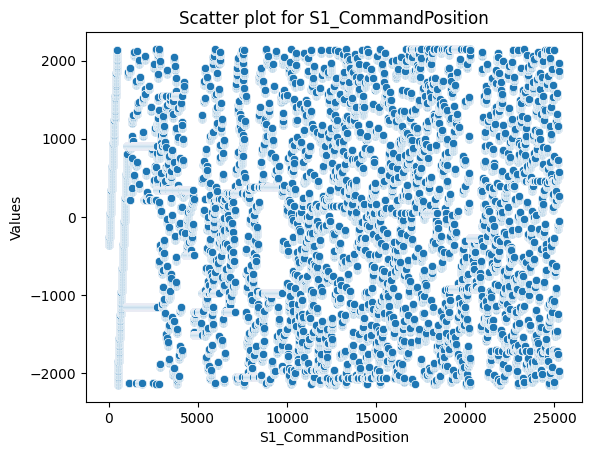

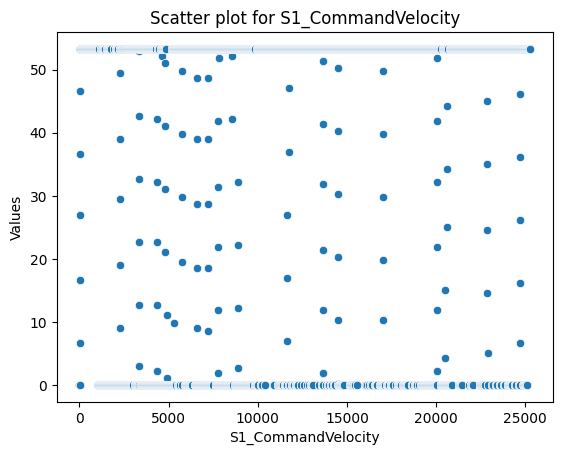

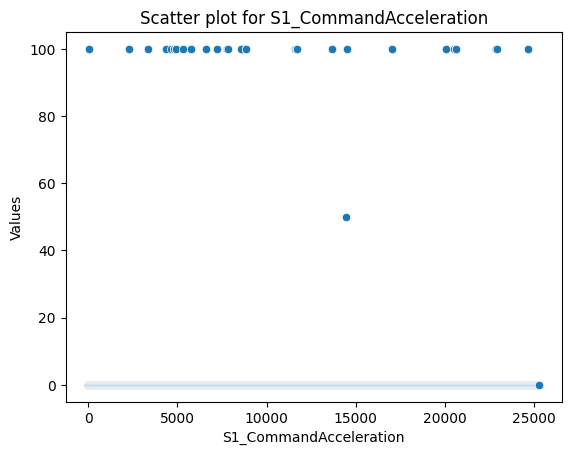

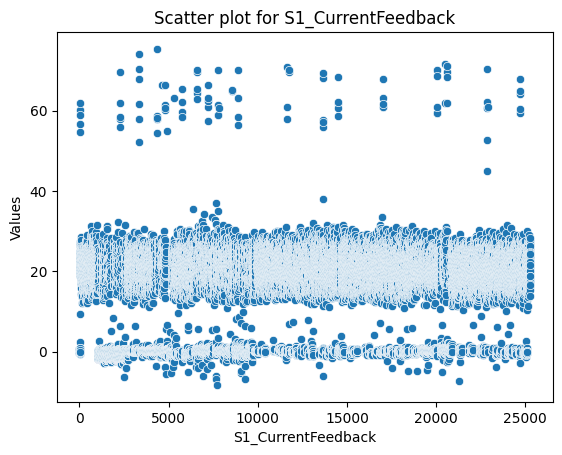

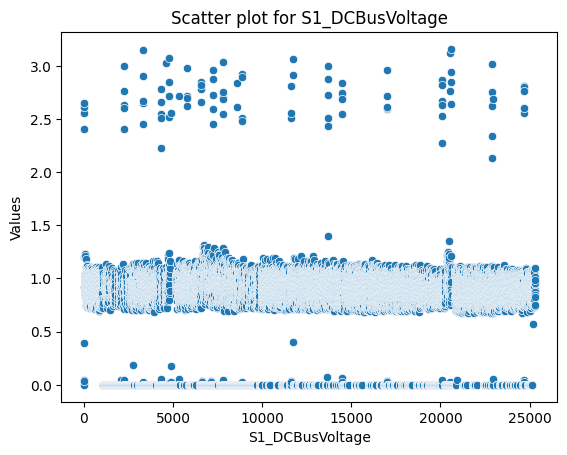

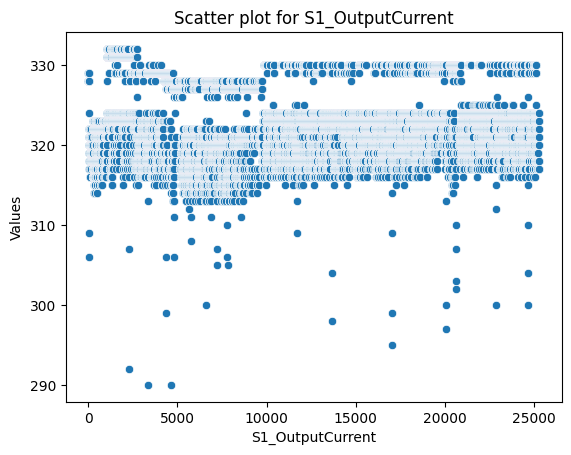

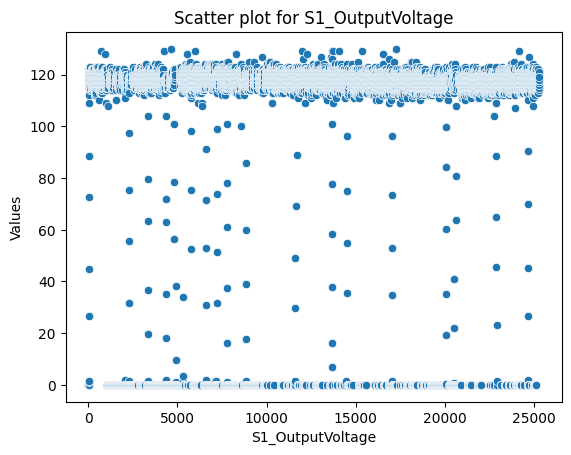

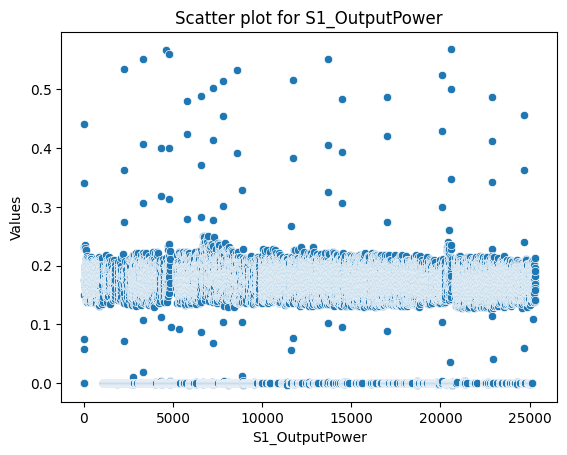

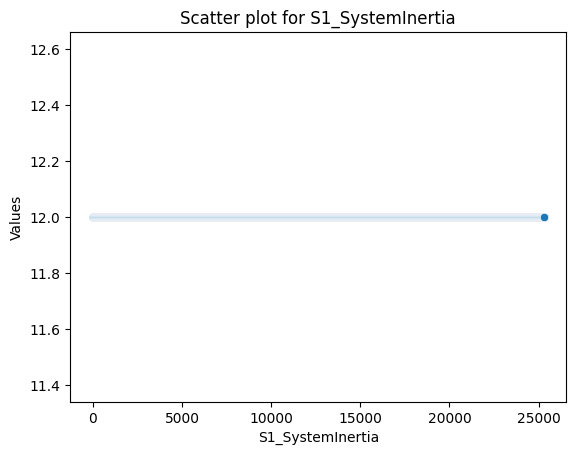

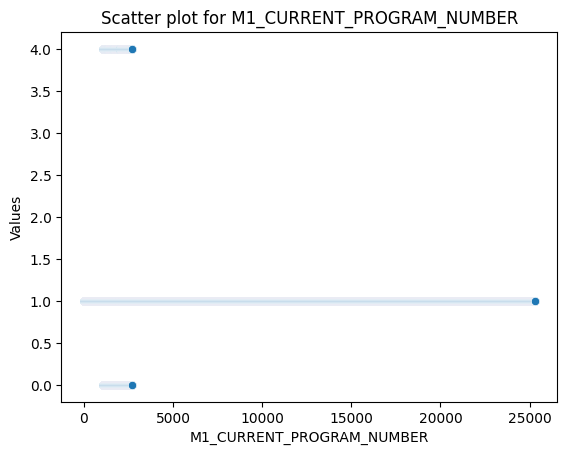

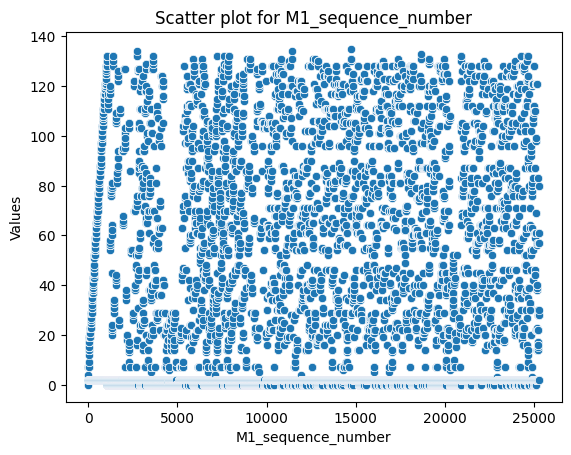

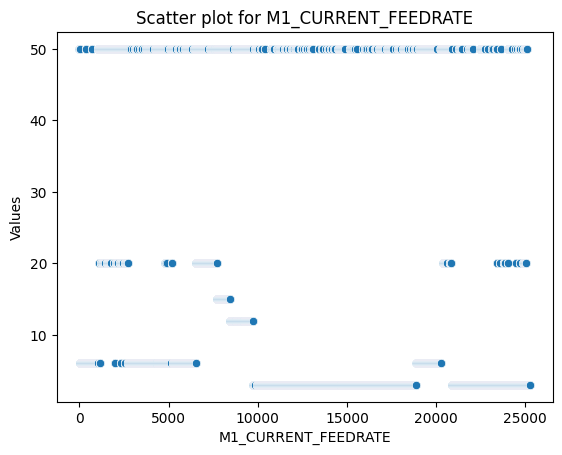

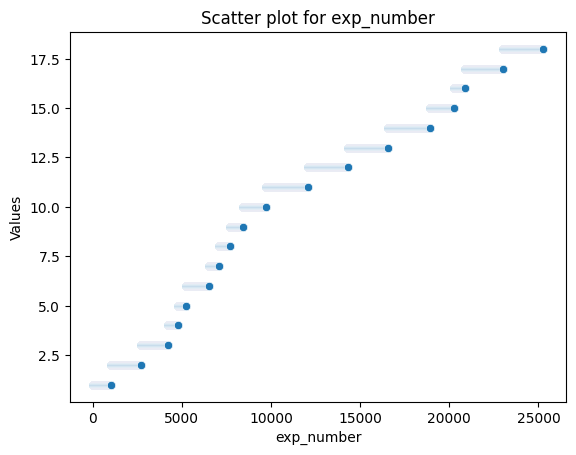

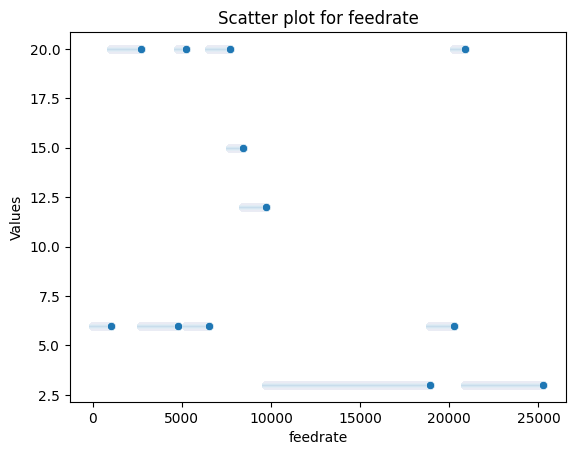

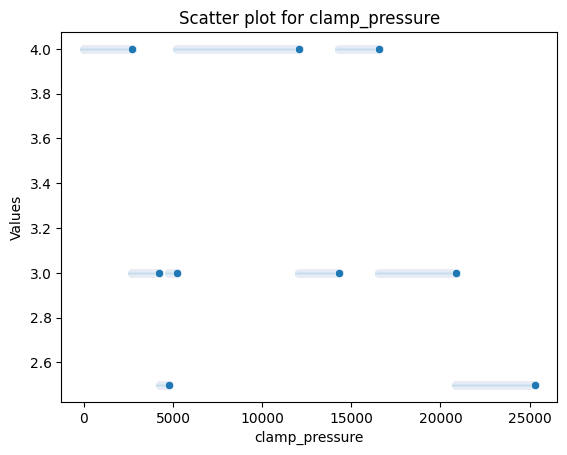

In [17]:
for i in df.columns:
    sns.scatterplot(df[i])
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.title(f'Scatter plot for {i}')
    plt.show()

#### Note
It seems that we have too many outliers, but since the number of outliers in each column is considerable, I assume that they are not the result of mistake or machine error. However, there are a few number of columns, X1_CurrentFeedback or X1_DCBusVoltage for example, which has a reasonable number of outliers. We can drop these rows or use the Winsorizing technique. I prefer not to do for now.

In [15]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers
for i in df.columns:
    outliers = find_outliers_IQR(df[i])
    print(f"number of outliers of {i}: "+ str(len(outliers)))
    print(f"max outlier value of {i}: "+ str(outliers.max()))
    print(f"min outlier value of {i}: "+ str(outliers.min()))
    print("------------------------------------\n")

number of outliers of X1_ActualPosition: 4463
max outlier value of X1_ActualPosition: 198.0
min outlier value of X1_ActualPosition: 188.0
------------------------------------

number of outliers of X1_ActualVelocity: 4040
max outlier value of X1_ActualVelocity: 50.7
min outlier value of X1_ActualVelocity: -20.4
------------------------------------

number of outliers of X1_ActualAcceleration: 908
max outlier value of X1_ActualAcceleration: 1440.0
min outlier value of X1_ActualAcceleration: -1280.0
------------------------------------

number of outliers of X1_CommandPosition: 4463
max outlier value of X1_CommandPosition: 198.0
min outlier value of X1_CommandPosition: 188.0
------------------------------------

number of outliers of X1_CommandVelocity: 4167
max outlier value of X1_CommandVelocity: 50.0
min outlier value of X1_CommandVelocity: -20.0
------------------------------------

number of outliers of X1_CommandAcceleration: 6796
max outlier value of X1_CommandAcceleration: 1000.0

#### Note
Ir remains to see what we have in the columns with binary values. We have three columns 'tool_condition', 'machining_finalized', and 'passed_visual_inspection'.

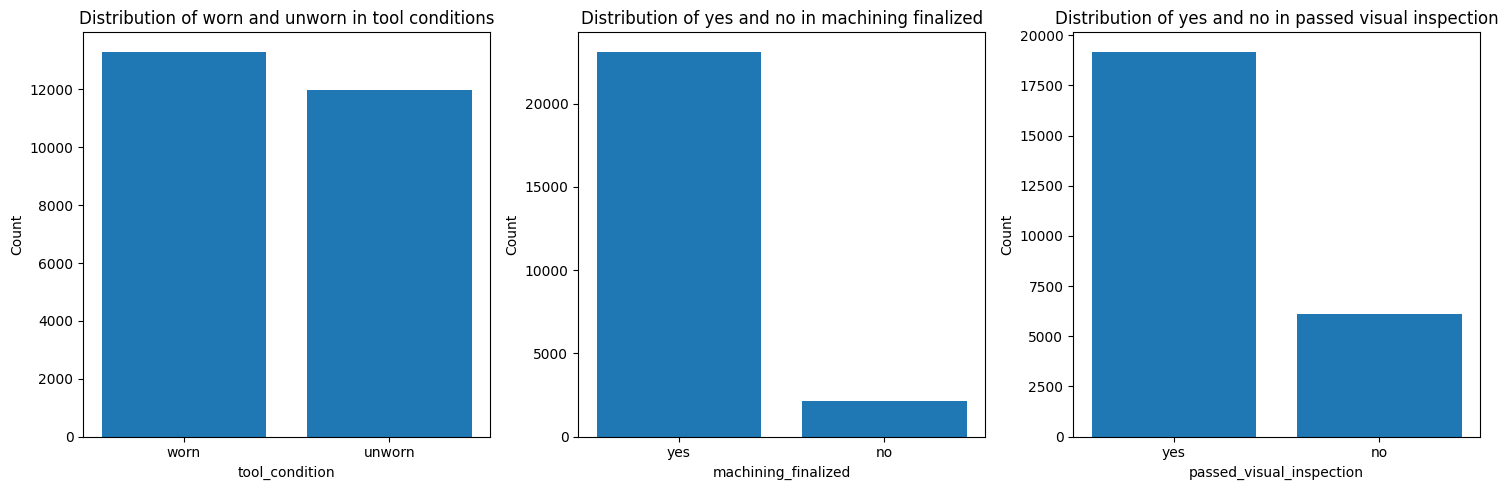

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(merged_data['tool_condition'].value_counts().index, merged_data['tool_condition'].value_counts().values)
axes[0].set_xlabel('tool_condition')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of worn and unworn in tool conditions')

axes[1].bar(merged_data['machining_finalized'].value_counts().index, merged_data['machining_finalized'].value_counts().values)
axes[1].set_xlabel('machining_finalized')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of yes and no in machining finalized')

axes[2].bar(merged_data['passed_visual_inspection'].value_counts().index, merged_data['passed_visual_inspection'].value_counts().values)
axes[2].set_xlabel('passed_visual_inspection')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of yes and no in passed visual inspection')

plt.tight_layout()

plt.show()


Machining Finalized for Worn Tools
 machining_finalized    no    yes
tool_condition                  
worn                 1167  12141
----------------------------------------
Machining Finalized for Unworn Tools
 machining_finalized   no    yes
tool_condition                 
unworn               994  10984
----------------------------------------



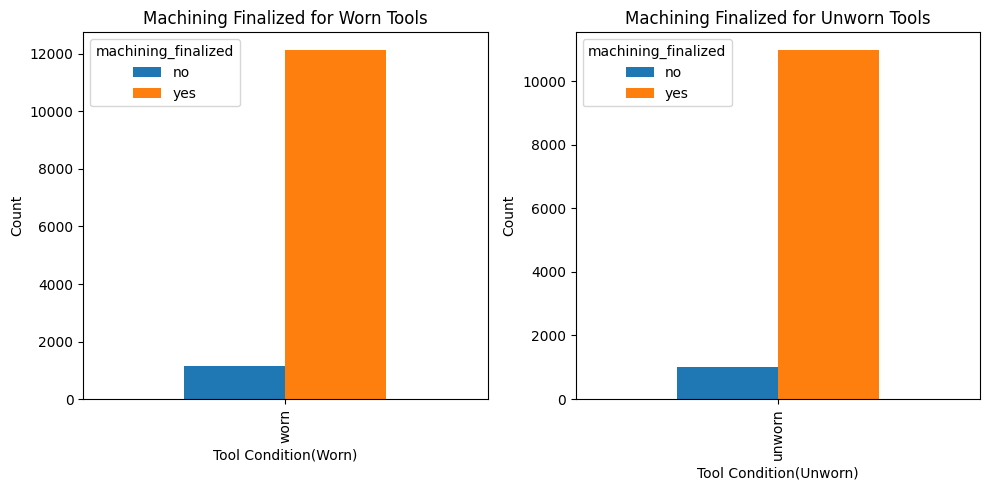

In [17]:
worn_tools = merged_data[merged_data['tool_condition'] == 'worn']
unworn_tools = merged_data[merged_data['tool_condition'] == 'unworn']

worn_tools_table = pd.crosstab(worn_tools['tool_condition'], worn_tools['machining_finalized'])
unworn_tools_table = pd.crosstab(unworn_tools['tool_condition'], unworn_tools['machining_finalized'])
print("Machining Finalized for Worn Tools\n",worn_tools_table)
print("----------------------------------------")
print("Machining Finalized for Unworn Tools\n",unworn_tools_table)
print("----------------------------------------\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

worn_tools_table.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Tool Condition(Worn)')
axes[0].set_ylabel('Count')
axes[0].set_title('Machining Finalized for Worn Tools')


unworn_tools_table.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Tool Condition(Unworn)')
axes[1].set_ylabel('Count')
axes[1].set_title('Machining Finalized for Unworn Tools')

#axes[0].legend(title='Finalized', fontsize=11)
#axes[1].legend(title='Finalized', fontsize=11)

plt.tight_layout()

plt.show()

Passed Visual Inspection for Worn Tools
 passed_visual_inspection    no   yes
tool_condition                      
worn                      5109  8199
----------------------------------------
Passed Visual Inspection for Unworn Tools
 passed_visual_inspection   no    yes
tool_condition                      
unworn                    994  10984
----------------------------------------



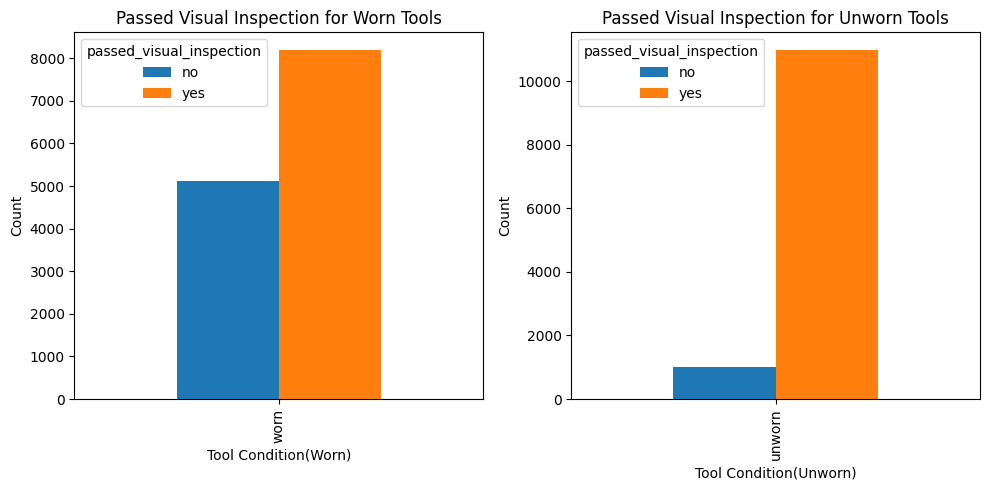

In [18]:
worn_tools_passed= pd.crosstab(worn_tools['tool_condition'], worn_tools['passed_visual_inspection'])
unworn_tools_passed=pd.crosstab(unworn_tools['tool_condition'], unworn_tools['passed_visual_inspection'])

print("Passed Visual Inspection for Worn Tools\n",worn_tools_passed)
print("----------------------------------------")
print("Passed Visual Inspection for Unworn Tools\n",unworn_tools_passed)
print("----------------------------------------\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

worn_tools_passed.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Tool Condition(Worn)')
axes[0].set_ylabel('Count')
axes[0].set_title('Passed Visual Inspection for Worn Tools')

unworn_tools_passed.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Tool Condition(Unworn)')
axes[1].set_ylabel('Count')
axes[1].set_title('Passed Visual Inspection for Unworn Tools')


plt.tight_layout()

plt.show()

Machining Finalized for Passed Visual Inspection
 machining_finalized         yes
passed_visual_inspection       
yes                       19183
----------------------------------------
Machining Finalized for Not Passed Visual Inspection
 machining_finalized         no   yes
passed_visual_inspection            
no                        2161  3942
----------------------------------------



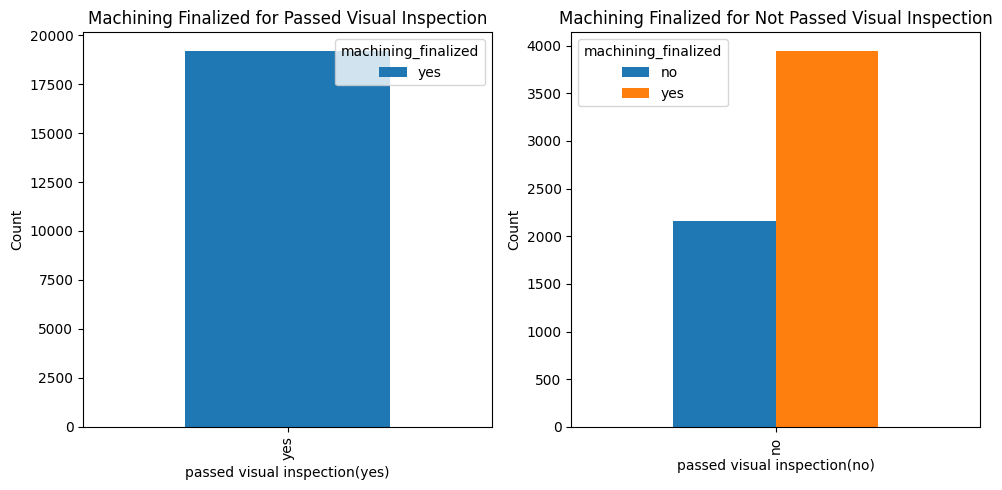

In [19]:
passed_visual = merged_data[merged_data['passed_visual_inspection'] == 'yes']
not_passed_visual = merged_data[merged_data['passed_visual_inspection'] == 'no']

passed_visual_tabel = pd.crosstab(passed_visual['passed_visual_inspection'], passed_visual['machining_finalized'])
not_passed_visual_tabel = pd.crosstab(not_passed_visual['passed_visual_inspection'], not_passed_visual['machining_finalized'])
print("Machining Finalized for Passed Visual Inspection\n",passed_visual_tabel)
print("----------------------------------------")
print("Machining Finalized for Not Passed Visual Inspection\n",not_passed_visual_tabel)
print("----------------------------------------\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

passed_visual_tabel.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('passed visual inspection(yes)')
axes[0].set_ylabel('Count')
axes[0].set_title('Machining Finalized for Passed Visual Inspection')

not_passed_visual_tabel.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('passed visual inspection(no)')
axes[1].set_ylabel('Count')
axes[1].set_title('Machining Finalized for Not Passed Visual Inspection')

plt.tight_layout()

plt.show()

#### Note
As we can see, for any "yes" result in the "passed_visual_inspection" column, the value of "machining_finalized" is also "yes". But still I think considering both values will show more accurate values in the model. So I keep them both.

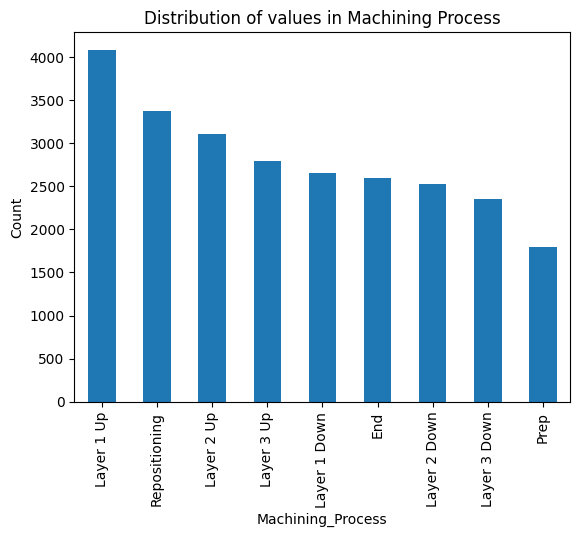

In [20]:
merged_data['Machining_Process'].value_counts().plot(kind='bar')
plt.xlabel('Machining_Process')
plt.ylabel('Count')
plt.title('Distribution of values in Machining Process')
plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

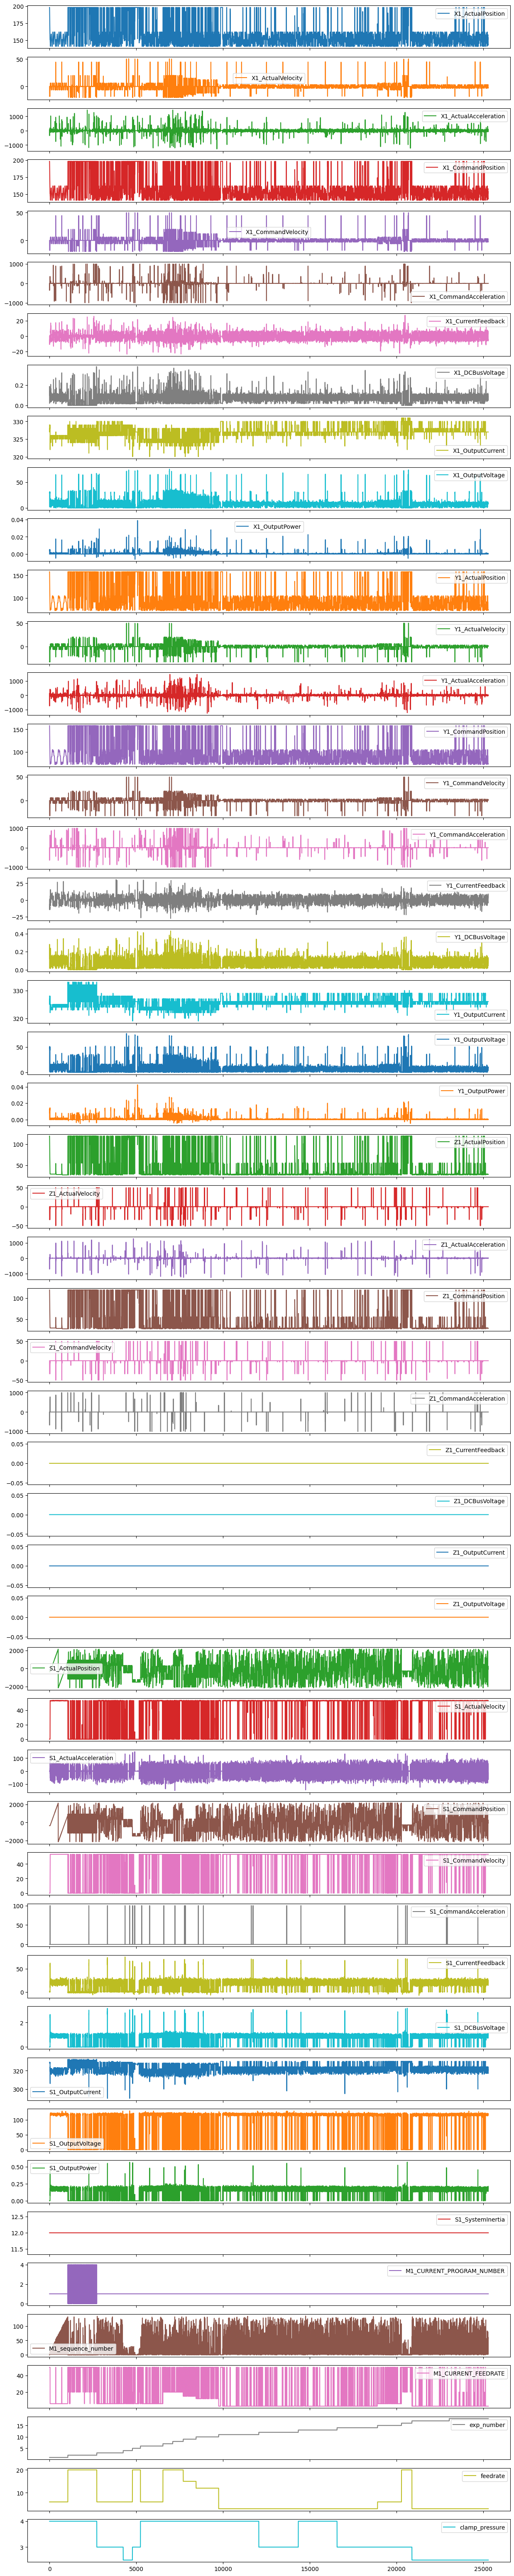

In [24]:
merged_data.plot.line(figsize=(15, 80),subplots=True)

#### Note
It seems from the plots that the four columns 'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', and 'Z1_OutputVoltage' have value zero and 'S1_SystemInertia' has value 12. 

In [15]:
merged_data['S1_SystemInertia'].unique()

array([12.])

In [16]:
z1_data=merged_data[['Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage','S1_SystemInertia']]
z1_data.describe()

Z1_CurrentFeedback  Z1_DCBusVoltage  Z1_OutputCurrent  \
count             25286.0          25286.0           25286.0   
mean                  0.0              0.0               0.0   
std                   0.0              0.0               0.0   
min                   0.0              0.0               0.0   
25%                   0.0              0.0               0.0   
50%                   0.0              0.0               0.0   
75%                   0.0              0.0               0.0   
max                   0.0              0.0               0.0   

       Z1_OutputVoltage  S1_SystemInertia  
count           25286.0           25286.0  
mean                0.0              12.0  
std                 0.0               0.0  
min                 0.0              12.0  
25%                 0.0              12.0  
50%                 0.0              12.0  
75%                 0.0              12.0  
max                 0.0              12.0

#### Note
Everything is zero, so I guess we can drop them without having influens on our data.

In [17]:
final_data=merged_data.drop(['Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage','S1_SystemInertia','exp_number'], axis=1)
final_data.head(2)

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0              -10.8                 -350.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0               -13.6                  -358.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   

   ...  S1_OutputPower  M1_CURRENT_PROGRAM_NUMBER  M1_sequence_number  \
0  ...    6.960000e-07                        1.0                 0.0   
1  ...   -5.270000e-07                        1.0                 4.0   

   M1_CURRENT_FEEDRATE  Machining_Process  feedrate  clamp_pressure  \
0                 50.0               Prep         6             4.0   
1                 50.0               Prep         6             4.0   

   tool_condition  machining_finalized  passed_visual_inspection  
0          unworn                  yes                       yes  
1          unworn                  yes                       yes  

[2 rows x 48 columns]

## Preparing data<a name =prepare></a>
Now we can prepare our data frames to be used in our model. We will look at columns and one hot or number the object columns.<br>
As it is mentioned in [Kaggle](https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill/data), the description states "independent observations", but I think there might be some implicit dependence within the "Machining_Process" stages. For example, successfully completing "Layer 1 Up" might be a prerequisite for attempting "Layer 1 Down". We can have two different approaches
1. Is to use all features and then predict the failiur or succes of the maching in the healthy text.
2. Drop the column "Machining_Process" and then predict the test result based on the other features. In this case, if the machine fails the test, we can look at the whole data frame and identify the problematic stage(s) by analyzing the data associated with the specific section of the "Machining_Process" where the predicted failure occurs.

First I will go with the first approach to see the result. Therefore, we should number the column "Machining_Process". I prefere to use Frequency Encoding method, I also use ohe hot encoding, and will chose the best one.

In [18]:
final_data["Machining_Process"].value_counts()

Machining_Process
Layer 1 Up       4085
Repositioning    3377
Layer 2 Up       3104
Layer 3 Up       2794
Layer 1 Down     2655
End              2593
Layer 2 Down     2528
Layer 3 Down     2354
Prep             1796
Name: count, dtype: int64

In [19]:
frequent_encoding_data=final_data.replace({'Layer 1 Up':9,'Repositioning':8,'Layer 2 Up':7,'Layer 3 Up':6,'Layer 1 Down':5,'End':4,'Layer 2 Down':3,'Layer 3 Down':2,'Prep':1})
frequent_encoding_data.head(2)

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0              -10.8                 -350.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0               -13.6                  -358.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   

   ...  S1_OutputPower  M1_CURRENT_PROGRAM_NUMBER  M1_sequence_number  \
0  ...    6.960000e-07                        1.0                 0.0   
1  ...   -5.270000e-07                        1.0                 4.0   

   M1_CURRENT_FEEDRATE  Machining_Process  feedrate  clamp_pressure  \
0                 50.0                  1         6             4.0   
1                 50.0                  1         6             4.0   

   tool_condition  machining_finalized  passed_visual_inspection  
0          unworn                  yes                       yes  
1          unworn                  yes                       yes  

[2 rows x 48 columns]

In [20]:
onehot_data=pd.get_dummies(final_data['Machining_Process'],dtype=int)
onehot_encoding_data=final_data.drop('Machining_Process',axis=1)
onehot_encoding_data.join(onehot_data)
onehot_encoding_data.head(2)

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                    0.0   
1              198.0              -10.8                 -350.0   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                     0.0   
1               198.0               -13.6                  -358.0   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   

   ...  S1_OutputVoltage  S1_OutputPower  M1_CURRENT_PROGRAM_NUMBER  \
0  ...               0.0    6.960000e-07                        1.0   
1  ...               0.0   -5.270000e-07                        1.0   

   M1_sequence_number  M1_CURRENT_FEEDRATE  feedrate  clamp_pressure  \
0                 0.0                 50.0         6             4.0   
1                 4.0                 50.0         6             4.0   

   tool_condition  machining_finalized  passed_visual_inspection  
0          unworn                  yes                       yes  
1          unworn                  yes                       yes  

[2 rows x 47 columns]

#### Note
The only remaining part now s to encode three columns, "tool_condition", "machining_finalized", and	"passed_visual_inspection". I prefer to put failuers as "0" and success as "1".

In [21]:
frequent_encoding_data.replace({'tool_condition':{'unworn':0,'worn':1},
                    'machining_finalized':{'no':0,'yes':1},
                    'passed_visual_inspection':{'no':0,'yes':1}},inplace=True)
onehot_encoding_data.replace({'tool_condition':{'unworn':0,'worn':1},
                    'machining_finalized':{'no':0,'yes':1},
                    'passed_visual_inspection':{'no':0,'yes':1}},inplace=True)

In [23]:
frequent_encoding_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

In [30]:
onehot_encoding_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

# Training model with Random Forest Classifier<a name=trainrf></a>
In this part we use random forest to predict the classification of the data. I will go first with predictiong 'tool_condition', using 'machining_finalized' and 'passed_visual_inspection' as the features. Then, I will use three of them as features and predict a new column 'machin_completed'.
First we see the result for frequent_encoding_data data frame.

In [24]:
X=frequent_encoding_data.drop('tool_condition',axis=1)
y=frequent_encoding_data['tool_condition']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [37]:
random_forest=RandomForestClassifier()
random_forest.get_params()
random_forest.fit(X_train,y_train)
y_pred=random_forest.predict(X_test)
accuracy_score(y_true=y_test,y_pred=y_pred)

0.9956504547251879

In [38]:
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[2336,   12],
       [  10, 2700]], dtype=int64)

#### Note
The result is good, but let's see if we can improve using `GridSearchCV` and `RandomizedSearchCV`.

In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [57]:
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=5)
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid, scoring='accuracy', cv=5, n_iter=100)

In [63]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy')

In [64]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   scoring='accuracy')

In [65]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_ 
print("grid_search best model: ", best_model)
print("grid_search best parameters: ", best_params)

grid_search best model:  RandomForestClassifier(max_depth=15, n_estimators=500)
grid_search best parameters:  {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}


In [66]:
print("best estimator for random search:",random_search.best_estimator_)
print("best parameter for random search:",random_search.best_params_ )

best estimator for random search: RandomForestClassifier(max_depth=15, n_estimators=200)
best parameter for random search: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}


In [67]:
boodted_random_forest_model=RandomForestClassifier(max_depth=15, n_estimators=500)
boodted_random_forest_model.get_params()
boodted_random_forest_model.fit(X_train,y_train)
y_pred_boost=boodted_random_forest_model.predict(X_test)
accuracy_score(y_true=y_test,y_pred=y_pred_boost)

0.994266508501384

In [68]:
boodted_random_forest_model2=RandomForestClassifier(max_depth=15, n_estimators=200)
boodted_random_forest_model2.get_params()
boodted_random_forest_model2.fit(X_train,y_train)
y_pred_boost2=boodted_random_forest_model.predict(X_test)
accuracy_score(y_true=y_test,y_pred=y_pred_boost2)

0.994266508501384

#### Note
As you can see, there is no big difference. So I prefer our original model. We now do the same for onehot_encoding_data.

In [39]:
X_oh=onehot_encoding_data.drop('tool_condition',axis=1)
y_oh=onehot_encoding_data['tool_condition']
X_train_oh, X_test_oh, y_train_oh, y_test_oh=train_test_split(X_oh,y_oh,test_size=0.2)

In [40]:
random_forest=RandomForestClassifier()
random_forest.get_params()
random_forest.fit(X_train_oh,y_train_oh)
y_pred_oh=random_forest.predict(X_test_oh)
accuracy_score(y_true=y_test_oh,y_pred=y_pred_oh)

0.9944642151047846

In [41]:
confusion_matrix(y_true=y_test_oh,y_pred=y_pred_oh)

array([[2409,    9],
       [  19, 2621]], dtype=int64)

#### Note
It seems the first dataframe ends up with a better result. 

# Training model with Decision Tree<a name=traindt></a>

In [42]:
decision_tree_model=DecisionTreeClassifier()
decision_tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [44]:
decision_tree_model.fit(X_train,y_train)
decision_tree_model.score(X_test,y_test)

0.9922894424673784

In [45]:
y_pred_dt=decision_tree_model.predict(X_test)
confusion_matrix(y_true=y_test,y_pred=y_pred_dt)

array([[2330,   18],
       [  21, 2689]], dtype=int64)

#### Note
Since the accuracy and confusion metrix don't seem to be very compatible, to be sure our model perform well, we use other metrics as well.

In [46]:
print("precision_score is:", precision_score(y_test, y_pred_dt))
print("----------------------------------------")
print("recall_score is:",recall_score(y_test, y_pred_dt))
print("----------------------------------------")
print("f1_score is:", f1_score(y_test, y_pred_dt))
print("----------------------------------------")
print("balanced_accuracy_score is:", balanced_accuracy_score(y_test, y_pred_dt))

precision_score is: 0.9933505725895826
----------------------------------------
recall_score is: 0.9922509225092251
----------------------------------------
f1_score is: 0.9928004430496585
----------------------------------------
balanced_accuracy_score is: 0.9922924118508647


#### Note
The same for our second data frame, "onehot_encoding_data".

In [47]:
decision_tree_model.fit(X_train_oh,y_train_oh)
decision_tree_model.score(X_train_oh,y_train_oh)

1.0

In [48]:
y_pred_oh_dt=decision_tree_model.predict(X_test_oh)
confusion_matrix(y_true=y_test_oh,y_pred=y_pred_oh_dt)

array([[2397,   21],
       [  34, 2606]], dtype=int64)

In [49]:
print("precision_score is:", precision_score(y_test_oh, y_pred_oh_dt))
print("----------------------------------------")
print("recall_score is:",recall_score(y_test_oh, y_pred_oh_dt))
print("----------------------------------------")
print("f1_score is:", f1_score(y_test_oh, y_pred_oh_dt))
print("----------------------------------------")
print("balanced_accuracy_score is:", balanced_accuracy_score(y_test_oh, y_pred_oh_dt))

precision_score is: 0.9920060905976399
----------------------------------------
recall_score is: 0.9871212121212121
----------------------------------------
f1_score is: 0.9895576229352573
----------------------------------------
balanced_accuracy_score is: 0.9892181742988194


# Training model with XGBoost Model<a name=trainxgb></a>

In [50]:
xgb_model=XGBClassifier()

In [51]:
xgb_model.fit(X_train,y_train)
xgb_model.score(X_test,y_test)

0.9990114669829973

In [52]:
y_pred_xgb=xgb_model.predict(X_test)
confusion_matrix(y_true=y_test,y_pred=y_pred_xgb)

array([[2346,    2],
       [   3, 2707]], dtype=int64)

In [53]:
xgb_model.fit(X_train_oh,y_train_oh)
xgb_model.score(X_train_oh,y_train_oh)

1.0

In [55]:
y_pred_oh_xgb=xgb_model.predict(X_test_oh)
confusion_matrix(y_true=y_test_oh,y_pred=y_pred_oh_xgb)

array([[2415,    3],
       [   8, 2632]], dtype=int64)

#### Note
Since the results show the models perfectly fitted, I use feature selection to see if we face data leakage or not. But the follwoing data results almost the same. So I think we can rely on our data and models. 

In [56]:
from sklearn.metrics import mutual_info_score
info_gain = [mutual_info_score(X.iloc[:, i], y) for i in range(X.shape[1])]

selected_features = pd.Series(info_gain).nlargest(30).index.astype(int).tolist()

X_info_gain = X.iloc[:, selected_features]
X_info_gain.head(2)

Z1_CommandPosition  Z1_ActualPosition  S1_CommandPosition  \
0               119.0              119.0              -361.0   
1               118.0              119.0              -361.0   

   S1_ActualPosition  S1_CurrentFeedback  Y1_OutputPower  X1_OutputPower  \
0             -361.0               0.524    6.430000e-07       -0.000001   
1             -361.0              -0.288    1.260000e-02        0.004480   

   Y1_CurrentFeedback  S1_DCBusVoltage  X1_CurrentFeedback  ...  \
0               0.539     2.740000e-19                0.18  ...   
1             -14.500     2.740000e-19              -10.90  ...   

   Y1_CommandAcceleration  X1_CommandAcceleration  X1_CommandVelocity  \
0                     0.0                     0.0                 0.0   
1                  -647.0                  -358.0               -13.6   

   Y1_CommandVelocity  S1_ActualAcceleration  X1_ActualVelocity  \
0                 0.0                   0.25                0.0   
1               -24.6                   0.25              -10.8   

   M1_CURRENT_FEEDRATE  M1_CURRENT_PROGRAM_NUMBER  Y1_ActualVelocity  \
0                 50.0                        1.0             -0.025   
1                 50.0                        1.0            -19.800   

   X1_ActualAcceleration  
0                    0.0  
1                 -350.0  

[2 rows x 30 columns]

In [57]:
y_pred_oh_xgb=xgb_model.predict(X_test_oh)
confusion_matrix(y_true=y_test_oh,y_pred=y_pred_oh_xgb)

array([[2415,    3],
       [   8, 2632]], dtype=int64)

In [58]:
X_train_new, X_test_new, y_train_new, y_test_new=train_test_split(X_info_gain,y,test_size=0.2)

In [59]:
xgb_model.fit(X_train_new,y_train_new)
xgb_model.score(X_test_new,y_test_new)

0.994661921708185

In [60]:
y_pred_xgb_new=xgb_model.predict(X_test_new)
confusion_matrix(y_true=y_test_new,y_pred=y_pred_xgb_new)

array([[2405,   10],
       [  17, 2626]], dtype=int64)

# Training model with RNN<a name=traincnn></a>

In [27]:
from tensorflow.keras.layers import TimeDistributed


# Define the model
X_train_reshaped = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))

model = tf.keras.Sequential([
    LSTM(64, return_sequences=True, input_shape=(1,47)),
    LSTM(32,return_sequences=True),
    LSTM(16,return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

X_test_array = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

loss, accuracy = model.evaluate(X_test_array, y_test)
y_proba = model.predict(X_test_array)
y_pred = (y_proba > 0.5).astype(int)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
confusion_matrix(y_test, y_pred)

Epoch 1/10
633/633 [==============================] - 14s 8ms/step - loss: 0.6838 - accuracy: 0.5566
Epoch 2/10
633/633 [==============================] - 4s 7ms/step - loss: 0.6707 - accuracy: 0.5759
Epoch 3/10
633/633 [==============================] - 5s 8ms/step - loss: 0.6666 - accuracy: 0.5657
Epoch 4/10
633/633 [==============================] - 5s 8ms/step - loss: 0.6664 - accuracy: 0.5633
Epoch 5/10
633/633 [==============================] - 5s 8ms/step - loss: 0.6415 - accuracy: 0.5993
Epoch 6/10
633/633 [==============================] - 5s 8ms/step - loss: 0.6326 - accuracy: 0.6050
Epoch 7/10
633/633 [==============================] - 5s 7ms/step - loss: 0.6513 - accuracy: 0.6021
Epoch 8/10
633/633 [==============================] - 5s 8ms/step - loss: 0.6503 - accuracy: 0.5968
Epoch 9/10
633/633 [==============================] - 5s 7ms/step - loss: 0.6542 - accuracy: 0.5877
Epoch 10/10
159/159 [==============================] - 3s 4ms/step
Test Loss: 0.6589, Test Accuracy

array([[ 236, 2211],
       [  60, 2551]], dtype=int64)

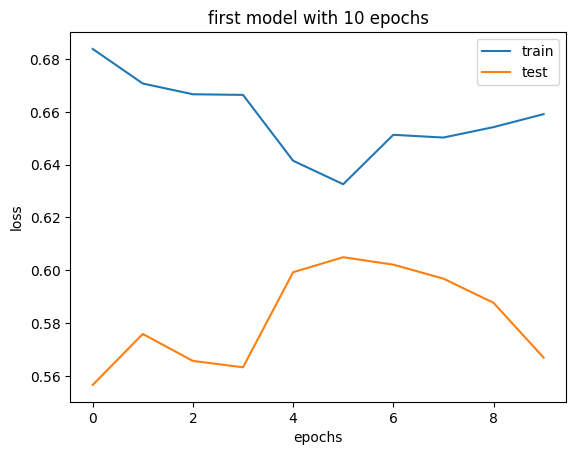

In [28]:
#visualization
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('first model with 10 epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper right')
plt.show()